In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [3]:
#Set dataset

datasetDirectory = ""

In [4]:
#Import raw JIRA dataset
rawData_JIRA_dataProcessing = pd.read_csv('../data/01_raw/JIRA Mendix.csv')
rawData_JIRA_academy = pd.read_excel('../data/01_raw/JIRA Mendix Academy export.xlsx')
rawData_JIRA_academyMay = pd.read_excel('../data/01_raw/JIRA Mendix Academy export_15_05_2021.xlsx')

#import
rawData_SVN_dataProcessing = loadCommits("../data/01_raw/data-processing-svn-dump.txt")
rawData_SVN_academy= loadCommits("../data/01_raw/academy-svn-dump.txt")

In [4]:
print(rawData_SVN_dataProcessing.head(10))

  revision                    email                         date  \
0        0                           2016-02-10T14:48:16.744857Z   
1        1                           2016-02-10T15:22:12.860242Z   
2        2        svnkid@mendix.com  2020-02-03T16:05:01.030210Z   
3        3  marios.lagos@mendix.com  2020-02-03T16:09:02.245673Z   
4        4  marios.lagos@mendix.com  2020-02-05T09:47:13.641688Z   
5        5  marios.lagos@mendix.com  2020-02-05T15:05:16.503294Z   
6        6  marios.lagos@mendix.com  2020-02-05T16:07:53.175098Z   
7        7  marios.lagos@mendix.com  2020-02-06T09:11:29.814130Z   
8        8  marios.lagos@mendix.com  2020-02-06T10:52:01.620399Z   
9        9  marios.lagos@mendix.com  2020-02-06T15:27:39.318859Z   

                                                                                                                                                                                                                                                   log  \
0

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [5]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [6]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dataProcessing = cleanCommitData(rawData_SVN_dataProcessing)
intermediateData_SVN_academy = cleanCommitData(rawData_SVN_academy)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dataProcessing.xlsx", index = False)
intermediateData_SVN_academy.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_academy.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_academy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 16.889185905456543 seconds


In [7]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


In [8]:
#Rename key to Issue key
rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dataProcessing = cleanJiraData(dataFrame = rawData_JIRA_dataProcessing, cleanComments = True, commentAmount = 39)
intermediateData_JIRA_academyMay = cleanJiraData(dataFrame = rawData_JIRA_academyMay, cleanComments = False, commentAmount = 0)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dataProcessing.xlsx", index = False)
intermediateData_JIRA_academyMay.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_academyMay.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

1/4) Finished Cleaning Summaries after 0.08459854125976562 sec
2/4) Finished Cleaning Description after 0.2972683906555176 sec
3/4) Finished Cleaning Dates after 0.2972683906555176 sec
4/4) Finished Cleaning Comments after 1.7346632480621338 sec
1/3) Finished Cleaning Summaries after 0.6390411853790283 sec
2/3) Finished Cleaning Description after 6.470965147018433 sec
3/3) Finished Cleaning Dates after 6.479018926620483 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [9]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [10]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Summary)
intermediateData_JIRA_dataProcessingCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Description)
intermediateData_JIRA_dataProcessingCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Comments)

#Create JIRA corpus for academy dataset
intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus = [i+" "+j+" "+ k for i,j,k in zip(intermediateData_JIRA_dataProcessingCorpusSummary,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription,
                                                                             intermediateData_JIRA_dataProcessingCorpusComments
                                                                            )]

intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

Bigram corpora

In [11]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [12]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Summary_2grams)
intermediateData_JIRA_dataProcessingCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Description_2grams)
intermediateData_JIRA_dataProcessingCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Comments_2grams)

#Create JIRA corpus for academy dataset
#intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
#intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus_2gram = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dataProcessingCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription_2grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusComments_2grams
                                                                                  )]

#intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
#                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus_2gram, f)
#with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
#    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [13]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

In [114]:
#Create corpus for log messages
intermediateData_SVNLogs_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs)
intermediateData_SVNLogs_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)
intermediateData_SVNLogs_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Unit_names)
intermediateData_SVNUnitNames_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dataProcessingCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs + intermediateData_SVN_dataProcessing.Unit_names)
intermediateData_SVN_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs + intermediateData_SVN_dataProcessing.Unit_names)

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNLogs_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_academyCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNUnitNames_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_academyCorpus, f)
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusAll, f)
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpus, f)  
    

bigram corpora

In [15]:
intermediateData_SVNLogs_dataProcessingCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dataProcessing.Logs_2grams)
intermediateData_SVNUnitNames_dataProcessingCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dataProcessing.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dataProcessingCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dataProcessingCorpus_2gram, f)

# 3. Preprocess Data

In [16]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_academy.pkl")



intermediateData_JIRA_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl')
intermediateData_JIRA_academyMayCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl')

intermediateData_SVN_dataProcessingCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl')
intermediateData_SVN_dataProcessingCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusModel.pkl')
intermediateData_SVN_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpus.pkl')
intermediateData_SVN_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [17]:
#Create cartesian products JIRA x Commits
processedData_dataProcessingCartesian = intermediateData_JIRA_dataProcessing.merge(intermediateData_SVN_dataProcessing, how='cross')
processedData_academyCartesian = intermediateData_JIRA_academyMay.merge(intermediateData_SVN_academy, how='cross')

processedData_dataProcessingCartesian = processedData_dataProcessingCartesian.drop(processedData_dataProcessingCartesian[processedData_dataProcessingCartesian.Jira_created_date > processedData_dataProcessingCartesian.Commit_date].index)
processedData_academyCartesian = processedData_academyCartesian.drop(processedData_academyCartesian[processedData_academyCartesian.Jira_created_date > processedData_academyCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_dataProcessingCartesian.to_pickle(path= "../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian.to_pickle(path= "../data/03_processed/processedData_academyCartesian.pkl")

## 3.1 Preprocess Data - Create Labels

In [18]:
#Create new dataFrames for the time features
processedData_dataProcessingLabels = pd.DataFrame() 
processedData_academyLabels = pd.DataFrame() 

#Create a column, which indicates which traces are valid.
processedData_dataProcessingLabels["is_valid"] = processedData_dataProcessingCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dataProcessing")
processedData_academyLabels["is_valid"] = processedData_academyCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for academy")

#Save intermediate results
processedData_dataProcessingLabels.to_pickle(path= "../data/03_processed/processedData_dataProcessingLabels.pkl")
processedData_academyLabels.to_pickle(path= "../data/03_processed/processedData_academyLabels.pkl")

processedData_dataProcessingLabels.head(10)

Finished creating labels for dataProcessing
Finished creating labels for academy


,is_valid
451,False
452,False
453,False
454,False
455,False
456,False
457,False
458,False
459,False
460,False


In [19]:
#processedData_dataProcessingLabels[processedData_dataProcessingLabels.is_valid == True].count()
processedData_dataProcessingLabels[processedData_dataProcessingLabels.is_valid == True].count()

is_valid    552
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [20]:
#Create new dataFrames for the time features
processedData_dataProcessingFeaturesTime = pd.DataFrame() 
processedData_academyFeaturesTime = pd.DataFrame() 

#Calculate the time features for data Processing Dataset
processedData_dataProcessingFeaturesTime['Creation_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Updated_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Resolved_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")


#Calculate the time features for academy Dataset
processedData_academyFeaturesTime['Creation_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Updated_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Resolved_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesTime.pkl")
processedData_academyFeaturesTime.to_pickle(path= "../data/03_processed/processedData_academyFeaturesTime.pkl")

Finished data Processing
Finished academy


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [21]:
#Create new dataFrames for the Stakeholder features
processedData_dataProcessingFeaturesStakeholder = pd.DataFrame() 
processedData_academyFeaturesStakeholder = pd.DataFrame() 

processedData_dataProcessingFeaturesStakeholder['Assignee_is_commiter'] = processedData_dataProcessingCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dataProcessing")
processedData_academyFeaturesStakeholder['Assignee_is_commiter'] = processedData_academyCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl")
processedData_academyFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_academyFeaturesStakeholder.pkl")

Finished dataProcessing
Finished academy


In [22]:
processedData_dataProcessingFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 451 to 33755
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  21712 non-null  float64
dtypes: float64(1)
memory usage: 434.6 KB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 DataProcessing - Cosine Similarity UniGrams

In [23]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [116]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dataProcessing               #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVN_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpus)

processedData_SVNLogs_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVNLogs_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_dataProcessingCountVectorizer, intermediateData_SVNLogs_dataProcessingCorpus)

processedData_SVNUnitNames_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_dataProcessingCountVectorizer, intermediateData_SVNUnitNames_dataProcessingCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

processedData_JIRASummaries_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRASummaries_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpusSummary)

processedData_JIRADescriptions_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpusDescription)

processedData_JIRAComments_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRAComments_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_dataProcessingCountVectorizer_2gram, intermediateData_SVNLogs_dataProcessingCorpus_2gram)

processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, intermediateData_SVNUnitNames_dataProcessingCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer_2gram, intermediateData_JIRA_dataProcessingCorpus_2gram)

processedData_JIRASummaries_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_dataProcessingCountVectorizer_2gram, intermediateData_JIRA_dataProcessingCorpusSummary_2grams)

processedData_JIRADescriptions_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_dataProcessingCountVectorizer_2gram, intermediateData_JIRA_dataProcessingCorpusDescription_2grams)

processedData_JIRAComments_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRAComments_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_dataProcessingCountVectorizer_2gram, intermediateData_JIRA_dataProcessingCorpusComments_2grams)







######################################################
#                       academy               #
######################################################

#instantiate CountVectorizer() for SVN
processedData_SVN_academyCountVectorizer = CountVectorizer()
processedData_SVN_academyCountTF_IDF = createFittedTF_IDF(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academyCorpus)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_academyCountVectorizer = CountVectorizer()
processedData_JIRA_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academyMayCorpus)

#instantiate CountVectorizer() for Model
#processedData_Model_academyCountVectorizer = CountVectorizer()
#processedData_Model_academyCountTF_IDF = createFittedTF_IDF(processedData_Model_academyCountVectorizer, intermediateData_SVN_academyCorpusModel)


#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 2 minutes and 31.218660831451416 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer, processedData_SVNLogs_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 27.715851545333862 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 31.251571893692017 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_dataProcessingCountVectorizer, processedData_JIRASummaries_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 3.7794361114501953 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer, processedData_SVNLogs_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 17.13146424293518 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_dataProcessingCountVectorizer, processedData_JIRASummaries_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 3.8229968547821045 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 8.476561307907104 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 2 minutes and 31.41038465499878 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 13.54487133026123 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dataProcessingCountVectorizer, processedData_JIRADescriptions_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 9.192991018295288 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 8.588143587112427 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentsUnitNamesCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentsUnitNamesCommentsAsQuery["vsm_comments_unitnames_comments_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dataProcessingCountVectorizer, processedData_JIRAComments_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentsUnitNamesCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentsUnitNamesCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.31296730041504 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentUnitNamesUnitNamesAsQuery["vsm_comments_unitnames_unitnames_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 12.57700490951538 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

In [38]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery["vsm_comments_comments_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dataProcessingCountVectorizer, processedData_JIRAComments_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.01286745071411 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentsLogsAsQuery["vsm_comments_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer, processedData_SVNLogs_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 20.917659044265747 seconds


#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

In [40]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram["vsm_comments_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 12.179398775100708 seconds


#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram["vsm_comments_comments_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dataProcessingCountVectorizer_2gram, processedData_JIRAComments_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 15.936609983444214 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [42]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 8.924676418304443 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_dataProcessingCountVectorizer, processedData_JIRADescriptions_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 9.684424638748169 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery["vsm_unitnames_comments_unitnames_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 12.336029767990112 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery["vsm_unitnames_comments_comments_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dataProcessingCountVectorizer, processedData_JIRAComments_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.56449317932129 seconds


In [46]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 31.903546810150146 seconds


In [48]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 21.13408064842224 seconds


In [50]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [51]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 16.64653754234314 seconds


In [52]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [53]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_dataProcessingCountVectorizer, processedData_JIRASummaries_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 4.344660997390747 seconds


In [54]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [55]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 57.684688091278076 seconds


In [56]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [57]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_dataProcessingCountVectorizer, processedData_JIRADescriptions_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 21.40352511405945 seconds


In [58]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [59]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery["vsm_svn_comments_svn_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 32.0343234539032 seconds


In [60]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

In [61]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery["vsm_svn_comments_comments_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_JIRAComments_dataProcessingCountVectorizer, processedData_JIRAComments_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 49.05760645866394 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [62]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 24.119723796844482 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dataProcessingCountVectorizer_2gram, processedData_JIRA_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 21.360565662384033 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer_2gram, processedData_SVNLogs_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 38.808985233306885 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer_2gram, processedData_JIRA_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 19.78572177886963 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 13.189361333847046 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 8.472291707992554 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dataProcessingCountVectorizer_2gram, processedData_JIRADescriptions_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 1 minutes and 14.46036672592163 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_dataProcessingCountVectorizer_2gram, processedData_JIRASummaries_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 7.101551294326782 seconds


## 3.6 Document Statistics

### dataProcessing

In [70]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesTotalWordCount["total_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesTotalWordCount["total_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")

processedData_JIRA_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 5.8755412101745605 seconds


## 3.7 Query Quality

In [71]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [72]:
#Read datasets from disk
processedData_dataProcessingCartesian = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian = pd.read_pickle(r"../data/03_processed/processedData_academyCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVN_dataProcessingTF_IDF = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

#Determine document counts
intermediateData_JIRA_dataProcessing_documentCount = len(intermediateData_JIRA_dataProcessing.index)
intermediateData_SVN_dataProcessing_documentCount = len(intermediateData_SVN_dataProcessing.index)



#### IDF Scores (SVN as Query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVN_dataProcessingTF_IDF),axis=1)

processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 6 minutes and 29.785033702850342 seconds


#### IDF Scores (SVNLogs as Query)

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVNLogs_dataProcessingCountTF_IDF),axis=1)

processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 2 minutes and 31.32548761367798 seconds


#### IDF Scores (SVNUnitNames as Query

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVNLogs_dataProcessingCountTF_IDF),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 2 minutes and 32.57910656929016 seconds


##### IDF Scores (JIRA as Query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRA_dataProcessingTF_IDF),axis=1)

processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 54 minutes and 25.414835453033447 seconds


##### IDF Scores (JIRA Summaries as Query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRASummaries_dataProcessingCountTF_IDF),axis=1)

processedData_JIRASummaries_dataProcessingFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 35.86350178718567 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountTF_IDF),axis=1)

processedData_JIRADescriptions_dataProcessingFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 3 minutes and 5.6995415687561035 seconds


##### IDF Scores (JIRA Comments as Query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesIDF["JiraCommentsAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Comments, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountTF_IDF),axis=1)

processedData_JIRAComments_dataProcessingFeaturesIDF["JiraCommentsAsQuery_avgIDF"] = processedData_JIRAComments_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dataProcessingFeaturesIDF["JiraCommentsAsQuery_maxIDF"] = processedData_JIRAComments_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dataProcessingFeaturesIDF["JiraCommentsAsQuery_devIDF"] = processedData_JIRAComments_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraCommentsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 19 minutes and 46.78744101524353 seconds


#### ICTF Scores (SVN as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 8.690936803817749 seconds


#### ICTF Scores (SVNLogs as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)
##
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 5.197134256362915 seconds


#### ICTF Scores (SVNUnitNames as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)
##
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 5.482113599777222 seconds


#### ICTF Scores (JIRA as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 27.335912466049194 seconds


#### ICTF Scores (JIRA Summaries as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 4.518993139266968 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 7.248025417327881 seconds


#### ICTF Scores (JIRA Comments as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Comments, 
                                                                                                                processedData_JIRAComments_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_avgICTF"] = processedData_JIRAComments_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraCommentsAsQuery_ICTF, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_maxICTF"] = processedData_JIRAComments_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraCommentsAsQuery_ICTF), axis=1)
processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_devICTF"] = processedData_JIRAComments_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraCommentsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 22.99805188179016 seconds


#### Entropy (SVN as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)

processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 10 minutes and 32.54348421096802 seconds


#### Entropy (SVNLogs as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Logs),axis=1)
##
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 56.03145408630371 seconds


#### Entropy (SVNUnitNames as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Unit_names),axis=1)
##
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 6 minutes and 1.1250073909759521 seconds


#### Entropy (JIRA as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)
##
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 37 minutes and 49.03392052650452 seconds


#### Entropy (JIRA Summaries as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Summary),axis=1)
##
processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 9.566722631454468 seconds


#### Entropy (JIRA Descriptions as query)

In [92]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Description),axis=1)
##
processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 46.290937185287476 seconds


#### Entropy (JIRA Comments as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Comments, 
                                                                                                                processedData_JIRAComments_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Comments),axis=1)
##
processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"] = processedData_JIRAComments_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_medEntropy"] = processedData_JIRAComments_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"] = processedData_JIRAComments_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_devEntropy"] = processedData_JIRAComments_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 26 minutes and 22.509210348129272 seconds


##### Query Scope (SVN as query)

In [94]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 51.86075973510742 seconds


##### Query Scope (SVNLogs as query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_dataProcessing.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 20.778152465820312 seconds


##### Query Scope (SVNUnitNames as query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_dataProcessing.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 16.94317078590393 seconds


##### Query Scope (JIRA as query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 9.325779438018799 seconds


##### Query Scope (JIRA Summaries as query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_dataProcessing.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 1.635702133178711 seconds


##### Query Scope (JIRA Descriptions as query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_dataProcessing.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 6.6733903884887695 seconds


##### Query Scope (JIRA Comments as query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesQueryScope["JiraCommentsAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Comments, 
                                                                                                                intermediateData_JIRA_dataProcessing.Comments),axis=1)

#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 8.652209997177124 seconds


#### Kullback-Leiber divergence (SVN as query)

In [101]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesSCS["SvnAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 4.935984373092651 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [102]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 0.6856110095977783 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [103]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 5.240624904632568 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [104]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCS["JiraAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 48.21213722229004 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [105]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 0.6363275051116943 seconds


In [106]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [107]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.2054359912872314 seconds


In [108]:
##### Kullback-Leiber divergence (JIRA Comments as query)

In [109]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesSCS["JiraCommentsAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Comments, 
                                                                                                                processedData_JIRAComments_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 36.86721849441528 seconds


#### SCQ (SVN as Query)

In [117]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_dataProcessing.Commit_natural_text,
                                                                                                                                         processedData_SVN_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVN_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 33.799092292785645 seconds


#### SCQ (SVNLogs as Query)

In [112]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_dataProcessing.Logs,
                                                                                                                                         processedData_SVNLogs_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVNLogs_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 30.984436750411987 seconds


#### SCQ (SVNUnitNames as Query)

In [113]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_dataProcessing.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 25.790761470794678 seconds


#### SCQ (JIRA as Query)

In [118]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dataProcessing.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRA_dataProcessingTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 14.510080814361572 seconds


#### SCQ (JIRA Summaries as Query)

In [119]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_dataProcessing.Summary,
                                                                                                                                         processedData_JIRASummaries_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 29.36058282852173 seconds


#### SCQ (JIRA Descriptions as Query)

In [120]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_dataProcessing.Description,
                                                                                                                                         processedData_JIRADescriptions_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 35.92243576049805 seconds


#### SCQ (JIRA Comments as Query)

In [121]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Comments, intermediateData_JIRA_dataProcessing.Comments,
                                                                                                                                         processedData_JIRAComments_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRAComments_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"] = processedData_JIRAComments_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraCommentsAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"] = processedData_JIRAComments_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)
processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"] = processedData_JIRAComments_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 6.2580671310424805 seconds


#### PMI (SVN as query)

In [122]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Commit_natural_text)

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)

processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_dataProcessingFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-71-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 10 minutes and 37.82093548774719 seconds


#### PMI (SVNLogs as query)

In [123]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Logs)

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Logs),axis=1)

processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_dataProcessingFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-71-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 3 minutes and 5.902086496353149 seconds


#### PMI (SVNUnitNames as query)

In [124]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Unit_names),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_dataProcessingFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-71-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 4 minutes and 43.68647122383118 seconds


#### PMI (JIRA as query)

In [125]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessing.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dataProcessing.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)

processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_dataProcessingFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 52 minutes and 58.565295934677124 seconds


#### PMI (JIRA Summaries as query)

In [126]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessing.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dataProcessing.Summary)

#Create new dataFrame
processedData_JIRASummaries_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dataProcessingFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dataProcessing.Summary),axis=1)

processedData_JIRASummaries_dataProcessingFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_dataProcessingFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_dataProcessingFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-71-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 0 minutes and 5.387423038482666 seconds


#### PMI (JIRA Descriptions as query)

In [127]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessing.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dataProcessing.Description)

#Create new dataFrame
processedData_JIRADescriptions_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dataProcessingFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dataProcessing.Description),axis=1)

processedData_JIRADescriptions_dataProcessingFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_dataProcessingFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_dataProcessingFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-71-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 1 minutes and 42.15343165397644 seconds


#### PMI (JIRA Comments as query)

In [128]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRAComments_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRAComments_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessing.Comments)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dataProcessing.Comments)

#Create new dataFrame
processedData_JIRAComments_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dataProcessingFeaturesPMI["JiraCommentsAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Comments, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dataProcessing.Comments),axis=1)

processedData_JIRAComments_dataProcessingFeaturesPMI["JiraCommentsAsQuery_avgPMI"] = processedData_JIRAComments_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraCommentsAsQuery_PMI), axis=1)
processedData_JIRAComments_dataProcessingFeaturesPMI["JiraCommentssAsQuery_maxPMI"] = processedData_JIRAComments_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraCommentsAsQuery_PMI), axis=1)



processedData_JIRAComments_dataProcessingFeaturesPMI.drop('JiraCommentsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRAComments_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 36 minutes and 19.274106979370117 seconds


In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [3]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_dataProcessingFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesTime.pkl')
processedData_dataProcessingFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.pkl')

processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmDescriptionLogsAsQuery.pkl')
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmCommentsCommentsAsQuery.pkl')
processedData_dataProcessing_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmCommentsLogsAsQuery.pkl')

processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
processedData_dataProcessingFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesQueryQuality.pkl')
processedData_SVN_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl')
processedData_SVNLogs_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesIDF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesIDF.pkl')
processedData_JIRA_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl')
processedData_JIRASummaries_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesIDF.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesIDF.pkl')
processedData_JIRAComments_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesIDF.pkl')


processedData_SVN_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesICTF.pkl')
processedData_SVNLogs_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesICTF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesICTF.pkl')
processedData_JIRA_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl')
processedData_JIRASummaries_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesICTF.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesICTF.pkl')
processedData_JIRAComments_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesICTF.pkl')


processedData_SVN_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesEntropy.pkl')
processedData_SVNLogs_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesEntropy.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesEntropy.pkl')
processedData_JIRA_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl')
processedData_JIRASummaries_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesEntropy.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesEntropy.pkl')
processedData_JIRAComments_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesEntropy.pkl')


processedData_SVN_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesQueryScope.pkl')
processedData_SVNLogs_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRASummaries_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRAComments_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesQueryScope.pkl')


processedData_SVN_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesSCS.pkl')
processedData_SVNLogs_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCS.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCS.pkl')
processedData_JIRA_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl')
processedData_JIRASummaries_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCS.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCS.pkl')
processedData_JIRAComments_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCS.pkl')


processedData_SVN_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesSCQ.pkl')
processedData_SVNLogs_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCQ.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCQ.pkl')
processedData_JIRA_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl')
processedData_JIRASummaries_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCQ.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCQ.pkl')
processedData_JIRAComments_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCQ.pkl')


processedData_SVN_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesPMI.pkl')
processedData_SVNLogs_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesPMI.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesPMI.pkl')
processedData_JIRA_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesPMI.pkl')
processedData_JIRASummaries_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesPMI.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesPMI.pkl')
processedData_JIRAComments_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_dataProcessingFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_dataProcessingFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_dataProcessingFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_dataProcessingFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_dataProcessingFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_dataProcessingFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRAComments_dataProcessingFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_dataProcessingFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_dataProcessingFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_dataProcessingFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_dataProcessingFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_dataProcessingFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_dataProcessingFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRAComments_dataProcessingFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_dataProcessingFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_dataProcessingFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_dataProcessingFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_dataProcessingFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_dataProcessingFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRAComments_dataProcessingFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_dataProcessingFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_dataProcessingFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_dataProcessingFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_dataProcessingFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_dataProcessingFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRAComments_dataProcessingFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_dataProcessingFeaturesTime_normalized = normalizeData(processedData_dataProcessingFeaturesTime)
processedData_dataProcessingFeaturesStakeholder_normalized = normalizeData(processedData_dataProcessingFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmLogsJiraAsQuery)
processedData_dataProcessing_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmLogsLogAsQuery)
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery)
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery)
processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery)
processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery)
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery)
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery)
processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmDescriptionLogsAsQuery)
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmCommentsCommentsAsQuery)
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmCommentsLogsAsQuery)

processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery)
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery)
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery)
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery)
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery)
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery)
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery)
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram)
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram)
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram)
processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmCommentsLogsAsQuery_2gram)
processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesUniqueWordCount)
processedData_SVN_dataProcessingFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesUniqueWordCount)
processedData_JIRA_dataProcessingFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesTotalWordCount)
processedData_SVN_dataProcessingFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesTotalWordCount)
processedData_JIRA_dataProcessingFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesOverlapPercentage)
processedData_SVN_dataProcessingFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesOverlapPercentage)
processedData_UNION_dataProcessingFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_dataProcessingFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesIDF)
processedData_SVNLogs_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesIDF)
processedData_SVNUnitNames_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesIDF)
processedData_JIRA_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesIDF)
processedData_JIRASummaries_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesIDF)
processedData_JIRADescriptions_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesIDF)
processedData_JIRAComments_dataProcessingFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesIDF)

processedData_SVN_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesICTF)
processedData_SVNLogs_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesICTF)
processedData_SVNUnitNames_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesICTF)
processedData_JIRA_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesICTF)
processedData_JIRASummaries_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesICTF)
processedData_JIRADescriptions_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesICTF)
processedData_JIRAComments_dataProcessingFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesICTF)

processedData_SVN_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesEntropy)
processedData_SVNLogs_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesEntropy)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesEntropy)
processedData_JIRA_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesEntropy)
processedData_JIRASummaries_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesEntropy)
processedData_JIRADescriptions_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesEntropy)
processedData_JIRAComments_dataProcessingFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesEntropy)

processedData_SVN_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesQueryScope)
processedData_SVNLogs_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesQueryScope)
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesQueryScope)
processedData_JIRA_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesQueryScope)
processedData_JIRASummaries_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesQueryScope)
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesQueryScope)
processedData_JIRAComments_dataProcessingFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesQueryScope)

processedData_SVN_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesSCS)
processedData_SVNLogs_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesSCS)
processedData_SVNUnitNames_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesSCS)
processedData_JIRA_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesSCS)
processedData_JIRASummaries_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesSCS)
processedData_JIRADescriptions_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesSCS)
processedData_JIRAComments_dataProcessingFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesSCS)

processedData_SVN_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesSCQ)
processedData_SVNLogs_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesSCQ)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesSCQ)
processedData_JIRA_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesSCQ)
processedData_JIRASummaries_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesSCQ)
processedData_JIRADescriptions_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesSCQ)
processedData_JIRAComments_dataProcessingFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesSCQ)

processedData_SVN_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_SVN_dataProcessingFeaturesPMI)
processedData_SVNLogs_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_dataProcessingFeaturesPMI)
processedData_SVNUnitNames_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_dataProcessingFeaturesPMI)
processedData_JIRA_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_JIRA_dataProcessingFeaturesPMI)
processedData_JIRASummaries_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_dataProcessingFeaturesPMI)
processedData_JIRADescriptions_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_dataProcessingFeaturesPMI)
processedData_JIRAComments_dataProcessingFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_dataProcessingFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [4]:

#Merge features into 1 dataframe
processedData_dataProcessingFeatures = pd.concat([processedData_dataProcessingFeaturesTime_normalized,
                                                  processedData_dataProcessingFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_dataProcessing_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmDescriptionLogsAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmCommentsCommentsAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery_normalized,
                                                  processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dataProcessingFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_dataProcessingFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_dataProcessingFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_dataProcessingFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_dataProcessingFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_dataProcessingFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_dataProcessingFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_dataProcessingFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dataProcessingFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dataProcessingFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_dataProcessingFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dataProcessingFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dataProcessingFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_JIRA_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_dataProcessingFeaturesQueryScope_normalized,
                                                  processedData_JIRAComments_dataProcessingFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_dataProcessingFeaturesSCS_normalized,
                                                  processedData_SVNLogs_dataProcessingFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCS_normalized,
                                                  processedData_JIRA_dataProcessingFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCS_normalized,
                                                  processedData_JIRAComments_dataProcessingFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_dataProcessingFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dataProcessingFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dataProcessingFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dataProcessingFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dataProcessingFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dataProcessingFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dataProcessingFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dataProcessingFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dataProcessingFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dataProcessingFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_dataProcessingFeatures = processedData_dataProcessingFeatures.fillna(0)

#Saving feature names for later use
processedData_dataProcessingFeatureNames = list(processedData_dataProcessingFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dataProcessingFeatures = np.array(processedData_dataProcessingFeatures)

#Load labels
processedData_dataProcessingLabels = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingLabels.pkl')
processedData_dataProcessingLabels = np.array(processedData_dataProcessingLabels["is_valid"])


In [19]:
for name in processedData_dataProcessingFeatureNames:
    print(name)

Creation_commit_date_dif
Updated_commit_date_dif
Resolved_commit_date_dif
Assignee_is_commiter
vsm_logs_jira_as_query
vsm_logs_log_as_query
vsm_unit_names_jira_as_query
vsm_unit_names_log_as_query
vsm_unitnames_comments_comments_as_query
vsm_unitnames_comments_unitnames_as_query
vsm_unitnames_description_description_as_query
vsm_unitnames_description_unitnames_as_query
vsm_summary_logs_summary_as_query
vsm_summary_logs_logs_as_query
vsm_summary_unitNames_summary_as_query
vsm_summary_unitNames_summary_as_query
vsm_description_description_as_query
vsm_description_log_as_query
vsm_comments_comments_as_query
vsm_comments_log_as_query
vsm_svn_jira_jira_as_query
vsm_svn_jira_svn_as_query
vsm_svn_summary_svn_as_query
vsm_svn_summary_summary_as_query
vsm_svn_description_svn_as_query
vsm_svn_description_description_as_query
vsm_svn_comments_svn_as_query
vsm_svn_comments_comments_as_query
unique_term_count_jira
unique_term_count_svn
total_term_count_jira
total_term_count_svn
overlap_percentage_c

In [6]:
#Load Process-Related Features
processedData_dataProcessingFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesTime.pkl')
processedData_dataProcessingFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
processedData_dataProcessingFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesQueryQuality.pkl')
processedData_SVN_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl')
processedData_SVNLogs_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesIDF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesIDF.pkl')
processedData_JIRA_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl')
processedData_JIRASummaries_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesIDF.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesIDF.pkl')
processedData_JIRAComments_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesIDF.pkl')

processedData_SVNLogs_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesICTF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesICTF.pkl')
processedData_JIRA_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl')
processedData_JIRASummaries_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesICTF.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesICTF.pkl')
processedData_JIRAComments_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesICTF.pkl')


processedData_SVNLogs_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesEntropy.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesEntropy.pkl')
processedData_JIRA_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl')
processedData_JIRASummaries_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesEntropy.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesEntropy.pkl')
processedData_JIRAComments_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesEntropy.pkl')


processedData_SVNLogs_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRASummaries_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRAComments_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesQueryScope.pkl')


processedData_SVNLogs_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCS.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCS.pkl')
processedData_JIRA_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl')
processedData_JIRASummaries_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCS.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCS.pkl')
processedData_JIRAComments_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCS.pkl')

processedData_SVNLogs_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCQ.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCQ.pkl')
processedData_JIRA_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl')
processedData_JIRASummaries_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesSCQ.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesSCQ.pkl')
processedData_JIRAComments_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesSCQ.pkl')


processedData_SVNLogs_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesPMI.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesPMI.pkl')
processedData_JIRA_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesPMI.pkl')
processedData_JIRASummaries_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dataProcessingFeaturesPMI.pkl')
processedData_JIRADescriptions_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dataProcessingFeaturesPMI.pkl')
processedData_JIRAComments_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dataProcessingFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_dataProcessingFeatures = pd.concat([processedData_dataProcessingFeaturesTime,
                                                  processedData_dataProcessingFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_dataProcessing_features_VsmLogsJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmLogsLogAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesCommentsCommentsAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_dataProcessing_features_VsmDescriptionLogsAsQuery,
                                                  processedData_dataProcessing_features_VsmCommentsCommentsAsQuery,
                                                  processedData_dataProcessing_features_VsmCommentsLogsAsQuery,
                                                 # processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnDescriptionDescriptionAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnCommentsSvnAsQuery,
                                                  processedData_dataProcessing_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dataProcessingFeaturesUniqueWordCount,
                                                  processedData_SVN_dataProcessingFeaturesUniqueWordCount,
                                                  processedData_JIRA_dataProcessingFeaturesTotalWordCount,
                                                  processedData_SVN_dataProcessingFeaturesTotalWordCount,
                                                  processedData_JIRA_dataProcessingFeaturesOverlapPercentage,
                                                  processedData_SVN_dataProcessingFeaturesOverlapPercentage,
                                                  processedData_UNION_dataProcessingFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dataProcessingFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dataProcessingFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dataProcessingFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dataProcessingFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesQueryScope,
                                                  processedData_SVNLogs_dataProcessingFeaturesQueryScope,
                                                  processedData_SVNUnitNames_dataProcessingFeaturesQueryScope,
                                                  processedData_JIRA_dataProcessingFeaturesQueryScope,
                                                  processedData_JIRASummaries_dataProcessingFeaturesQueryScope,
                                                  processedData_JIRADescriptions_dataProcessingFeaturesQueryScope,
                                                  processedData_JIRAComments_dataProcessingFeaturesQueryScope,
                                                  
                                                  processedData_SVN_dataProcessingFeaturesSCS,
                                                  processedData_SVNLogs_dataProcessingFeaturesSCS,
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCS,
                                                  processedData_JIRA_dataProcessingFeaturesSCS,
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCS,
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCS,
                                                  processedData_JIRAComments_dataProcessingFeaturesSCS,
                                                  
                                                  processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dataProcessingFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dataProcessingFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dataProcessingFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dataProcessingFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dataProcessingFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_dataProcessingFeatures = processedData_dataProcessingFeatures.fillna(0)

#Saving feature names for later use
processedData_dataProcessingFeatureNames = list(processedData_dataProcessingFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dataProcessingFeatures = np.array(processedData_dataProcessingFeatures)

#Load labels
processedData_dataProcessingLabels = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingLabels.pkl')
processedData_dataProcessingLabels = np.array(processedData_dataProcessingLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [41]:
features = processedData_dataProcessingFeatures
labels = processedData_dataProcessingLabels

In [42]:
processedData_dataProcessingFeatures

array([[9.99944205e-01, 6.34536381e-01, 5.21119740e-01, ...,
        1.00000000e+00, 5.41147582e-01, 1.00000000e+00],
       [9.99859111e-01, 6.34481955e-01, 5.21049162e-01, ...,
        1.00000000e+00, 5.41147582e-01, 1.00000000e+00],
       [9.99696811e-01, 6.34378147e-01, 5.20914547e-01, ...,
        1.00000000e+00, 5.41147582e-01, 1.00000000e+00],
       ...,
       [3.21965973e-04, 4.20702622e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.51623733e-05, 4.20557557e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.20496691e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [43]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 21817, True: 435})


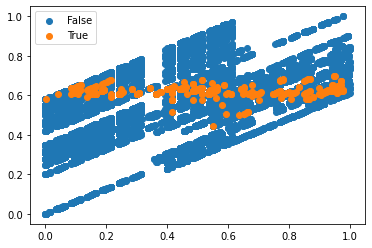

Counter({False: 10908, True: 10908})


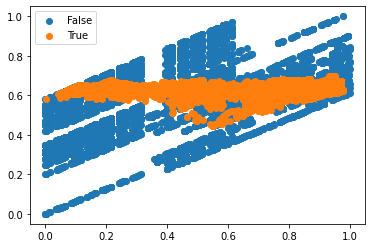

In [44]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1    F2      F0.5  Average Precision
0  0.987597   0.958333  0.40708  0.571429  0.46  0.754098           0.402162

--------------------------------------------------------------------


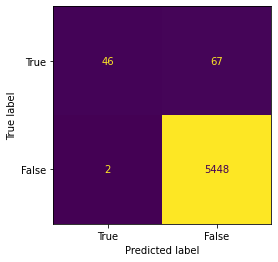

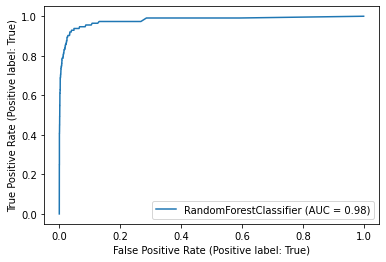

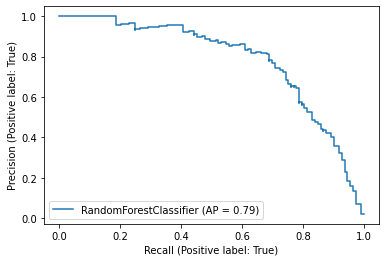

In [161]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


Elapsed time to compute the importances: 0.100 seconds


<ipython-input-162-ba07509e8bc7>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


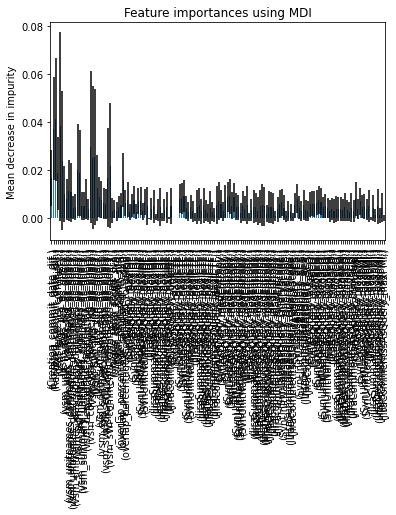

In [162]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_dataProcessingFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

C:\Users\rande\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.991911   0.887097  0.591398  0.709677  0.633641  0.806452   

   Average Precision  
0           0.531458  

--------------------------------------------------------------------


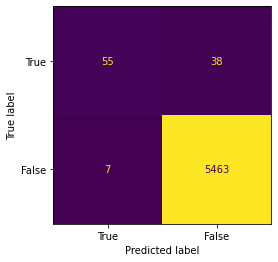

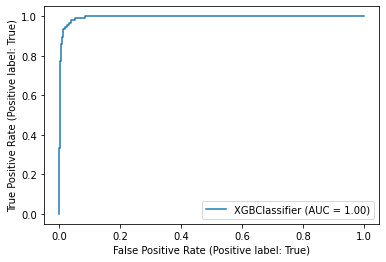

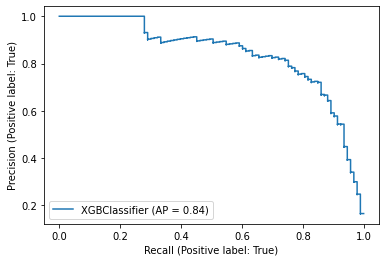

In [170]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.99227   0.948718  0.654867  0.774869  0.698113  0.870588   

   Average Precision  
0           0.628295  

--------------------------------------------------------------------


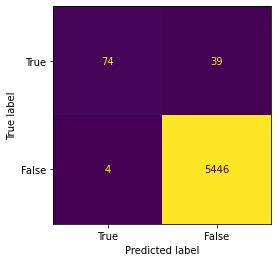

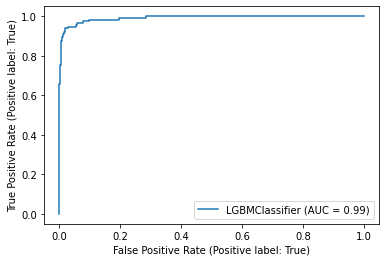

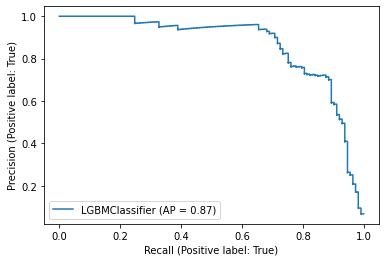

In [164]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model - Pipeline for GXBoost

In [610]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]
spaceEmpty = dict()

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\rande\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2.234 seconds


Cross-validation score: 0.36380801269156104
Test score: 0.3215926493108729
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.920367    0.19337  0.954545  0.321593  0.534079  0.230061   

   Average Precision  
0           0.185479  

--------------------------------------------------------------------


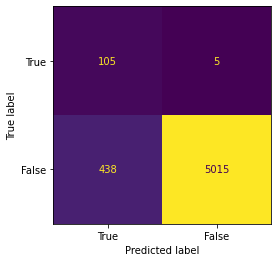

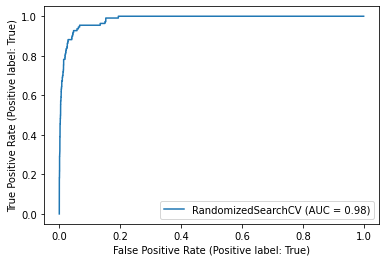

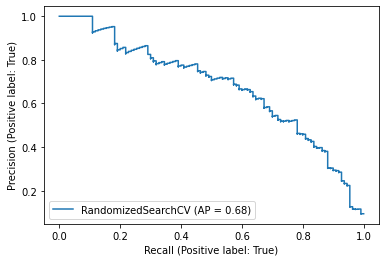

In [611]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:49:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2545.430 seconds
Cross-validation score: 0.8167223944855134
Test score: 0.8128078817733991
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.7}
0.007281476
0.018464351
0.023875607
0.025997376
0.04181718
0.005465189
0.00510045
0.0046661585
0.007331195
0.013865477
0.0037738648
0.0054520844
0.007657931
0.007862103
0.0037783044
0.0026105952
0.0035038418
0.003043904
0.021746086
0.012079642
0.018516544
0.0045451475
0.009676939
0.0068575037
0.00608373
0.0034997123
0.011626655
0.008682646
0.017088542
0.014224678
0.0070337555
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2435.033 seconds
Cross-validation score: 0.8043926061817877
Test score: 0.829596412556054
Best Hyperparameters: {'classifier__min_child_weight': 4, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.8}
0.007676951
0.020668982
0.020259239
0.022689521
0.034904808
0.0067764833
0.0063074995
0.0023434036
0.0058383266
0.010452184
0.005129533
0.0061474084
0.013609461
0.0073813004
0.0019136032
0.0070417835
0.0041104276
0.0029599022
0.032316633
0.010640346
0.029556386
0.008166616
0.0062688044
0.0057428805
0.002693792
0.0032636842
0.0041357186
0.016072247
0.00872256
0.006401137
0.0111823

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2363.527 seconds
Cross-validation score: 0.8149319815197398
Test score: 0.8296943231441049
Best Hyperparameters: {'classifier__min_child_weight': 2, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.5}
0.009290264
0.023150334
0.026473453
0.02938298
0.03314019
0.0036572267
0.00636691
0.0048460304
0.008115809
0.0069916667
0.007915451
0.003452132
0.011512684
0.009608752
0.0043348446
0.003821761
0.0037822563
0.0038563034
0.020725083
0.012167715
0.02161679
0.0113908965
0.005045168
0.0062256344
0.0035850066
0.005472013
0.0133123165
0.012435592
0.007815735
0.0030488058
0.006082208
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:48:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2338.636 seconds
Cross-validation score: 0.8042120224537681
Test score: 0.8014354066985646
Best Hyperparameters: {'classifier__min_child_weight': 2, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.4}
0.010833338
0.025691502
0.02852505
0.03323617
0.03195603
0.0034405217
0.0072132587
0.005505239
0.0060301274
0.01139525
0.007756061
0.002924345
0.012392439
0.009180396
0.009184846
0.00250997
0.0048413803
0.006108761
0.021019638
0.012013073
0.02473127
0.006018019
0.004319867
0.0060917987
0.0034862955
0.0036104708
0.013881609
0.012834517
0.0032905035
0.002611803
0.0075748595
0.0019

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2629.491 seconds
Cross-validation score: 0.8043586539120782
Test score: 0.8191489361702127
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.35, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 1.0}
0.011876297
0.018861698
0.023071026
0.030363705
0.038634814
0.002836783
0.004308014
0.004155167
0.0040352936
0.028315919
0.005091539
0.0032763237
0.014093682
0.0066465
0.0053090323
0.0
0.0022778483
0.0
0.016700342
0.0056842314
0.016094172
0.0043051206
0.004309103
0.009468795
0.005738108
0.0043231314
0.005194076
0.0045939214
0.0125424815
0.010252549
0.00716475
0.004661274
0.0024

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2382.969 seconds
Cross-validation score: 0.8205570658115047
Test score: 0.7555555555555556
Best Hyperparameters: {'classifier__min_child_weight': 2, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}
0.013261649
0.024590692
0.02083528
0.022025723
0.040008076
0.003967788
0.01343389
0.0021965727
0.0049041985
0.018378684
0.002318568
0.0034490097
0.014729359
0.006028521
0.0026588924
0.0022458527
0.0024031578
0.0
0.016778471
0.0058771935
0.015048684
0.004105076
0.0073490585
0.003564527
0.0019009402
0.0027942176
0.014610999
0.016442623
0.014157933
0.0045382944
0.0035504024
0.00627

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:53:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2479.176 seconds
Cross-validation score: 0.7997318369248145
Test score: 0.8116883116883118
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.9}
0.011247816
0.026023256
0.02353506
0.0369819
0.03701765
0.0048608007
0.007316042
0.003453388
0.007588155
0.023302885
0.0035215165
0.0025496262
0.009723531
0.0066570477
0.003331809
0.0029909231
0.004657926
0.0
0.013412728
0.008951792
0.015876189
0.006036483
0.0056280433
0.00690044
0.002284664
0.0047520897
0.0073431856
0.008067728
0.00759255
0.016878864
0.0029931767
0.0048171566


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_enco

[05:31:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2298.654 seconds
Cross-validation score: 0.8050481948073134
Test score: 0.8255813953488371
Best Hyperparameters: {'classifier__min_child_weight': 3, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.7}
0.012380048
0.020673757
0.023223586
0.020341864
0.025554359
0.004160489
0.008590376
0.0045822174
0.0070059034
0.021447435
0.0038453229
0.0060045966
0.011572357
0.0084585
0.0017465951
0.0056430805
0.0036253373
0.00373619
0.044729933
0.012715083
0.013489425
0.011099201
0.0043512303
0.005915737
0.004022156
0.0026670867
0.0058351485
0.012437471
0.013089441
0.0010448591
0.0047688456


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2309.889 seconds
Cross-validation score: 0.8158888860580428
Test score: 0.8195020746887965
Best Hyperparameters: {'classifier__min_child_weight': 3, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.55, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}
0.009012999
0.027805174
0.025472282
0.033926737
0.04729853
0.0022358738
0.005942071
0.0044873827
0.012335327
0.023874413
0.010941397
0.0020491416
0.028969882
0.008008835
0.002201361
0.0
0.0012673808
0.0
0.015637536
0.0062088114
0.022109529
0.002852468
0.0044598463
0.0007310174
0.003412019
0.0038158025
0.009855093
0.016979711
0.0062094363
0.0018381655
0.010094442
0.0009350573
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:53:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2560.020 seconds
Cross-validation score: 0.8026670671703586
Test score: 0.8179723502304148
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.35, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}
0.005487835
0.028778834
0.02102389
0.024802914
0.044787753
0.0036129039
0.0067680795
0.0037044922
0.0105655845
0.016256262
0.0
0.0039378367
0.014934776
0.013198268
0.0046072113
0.0
0.0041308687
0.0
0.02497877
0.008051906
0.026477112
0.013521731
0.008681753
0.0059240325
0.0026549336
0.003583452
0.005861302
0.011235817
0.0057652756
0.004942177
0.010340864
0.012992806
0.008125069


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2729.006 seconds
Cross-validation score: 0.8130190407972536
Test score: 0.8091787439613527
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.8}
0.008810815
0.01867
0.017983261
0.021330807
0.04317619
0.0041820207
0.01164744
0.0044367188
0.0047095264
0.017149255
0.0071199764
0.004859748
0.00946001
0.008253766
0.0029238756
0.0
0.0045860624
0.0
0.030569468
0.0070353025
0.02041391
0.01892381
0.0065305517
0.00647752
0.005935614
0.0059778746
0.008299314
0.008788595
0.010472042
0.008667548
0.011906478
0.0030369274
0.0037555618


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


--------------------------------------------------------------------
[08:19:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2467.151 seconds
Cross-validation score: 0.808488353634646
Test score: 0.7555555555555556
Best Hyperparameters: {'classifier__min_child_weight': 4, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.4, 'classifier__colsample_bytree': 0.3}
0.008656274
0.023824748
0.031179933
0.029539423
0.02823872
0.0022751985
0.0038857437
0.003182707
0.0055736196
0.00920295
0.0074998247
0.005110441
0.011594411
0.008674544
0.003727495
0.005592718
0.0057021566
0.0034210219
0.015609886
0.012010266
0.024482386
0.006917751
0.0045291274
0.0056428113
0.0041832426
0.0041

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2378.921 seconds
Cross-validation score: 0.8228934159205373
Test score: 0.7594936708860759
Best Hyperparameters: {'classifier__min_child_weight': 4, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.45, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.7}
0.010152786
0.027716484
0.024908448
0.020503078
0.038126532
0.003505882
0.011532842
0.0034775464
0.0033136646
0.022046817
0.008062768
0.0049136747
0.013106319
0.007802836
0.0016319485
0.0016418771
0.002361628
0.0
0.029155621
0.012578904
0.022155153
0.0017112016
0.0030223918
0.004085967
0.001705842
0.0046674376
0.004952858
0.013363996
0.012110458
0.0016155782
0.007936373
0.0
0.00

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2335.577 seconds
Cross-validation score: 0.8183918537261737
Test score: 0.7701421800947867
Best Hyperparameters: {'classifier__min_child_weight': 3, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.9}
0.008233023
0.023323629
0.025566678
0.024128633
0.035532963
0.003816292
0.006786971
0.0033050657
0.007155537
0.012265655
0.0025307764
0.005055425
0.009047088
0.0091299545
0.008837181
0.0
0.0036173256
0.0
0.010512877
0.006488591
0.025119487
0.0075458386
0.006242787
0.007813279
0.0033278014
0.003285282
0.0049616103
0.00467337
0.007940962
0.00440156
0.0152364075
0.002801472
0.00388

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2375.008 seconds
Cross-validation score: 0.8078667116433877
Test score: 0.8149779735682818
Best Hyperparameters: {'classifier__min_child_weight': 5, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.4}
0.010857323
0.024605704
0.029680159
0.02687071
0.041670457
0.003612283
0.004153611
0.0027728064
0.008411378
0.010393756
0.003895015
0.003508153
0.014080356
0.007988613
0.0036433472
0.0074268407
0.0057381024
0.004746991
0.022818776
0.016499491
0.022907676
0.0090784505
0.0034805208
0.0063412874
0.003491146
0.0033752227
0.018236062
0.014929686
0.004430189
0.0032593866
0.004270799
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 2390.475 seconds
Cross-validation score: 0.8085467787962319
Test score: 0.7971014492753622
Best Hyperparameters: {'classifier__min_child_weight': 7, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.8}
0.010080633
0.021333104
0.021555157
0.022121413
0.0326544
0.0046664756
0.0060118064
0.004465806
0.009138556
0.016897727
0.002591907
0.005430842
0.010664853
0.0063863597
0.0055951937
0.0038829034
0.0049598594
0.0
0.04564909
0.022168444
0.020353626
0.005011038
0.0062267063
0.0024018828
0.011754217
0.0030276116
0.006463856
0.011452812
0.007013957
0.010975156
0.0055805086
0.0
0.004

KeyboardInterrupt: 

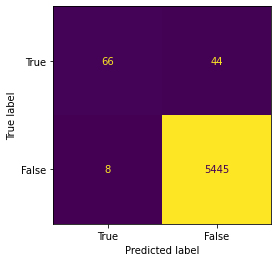

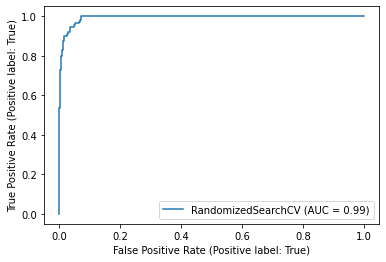

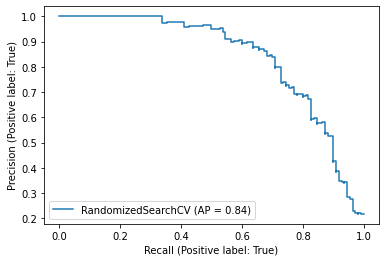

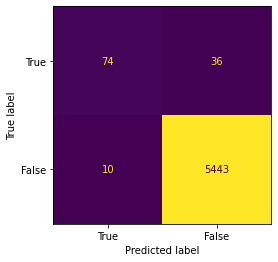

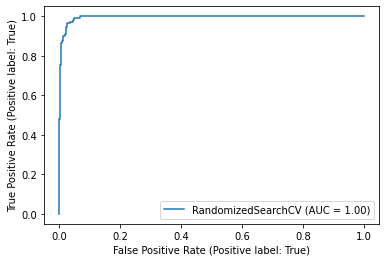

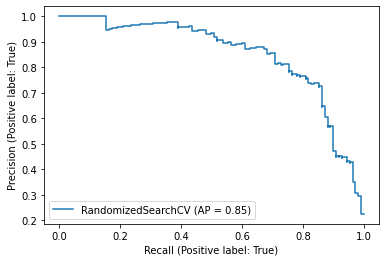

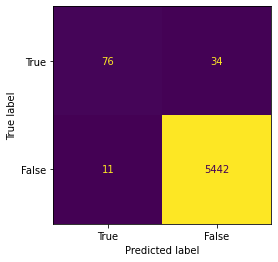

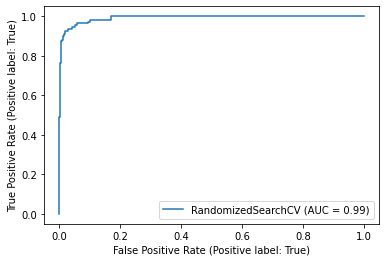

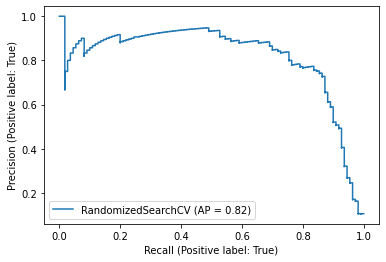

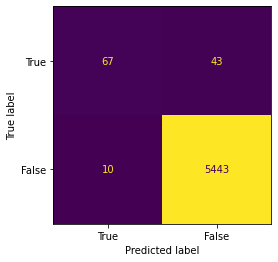

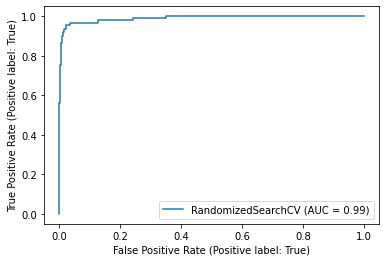

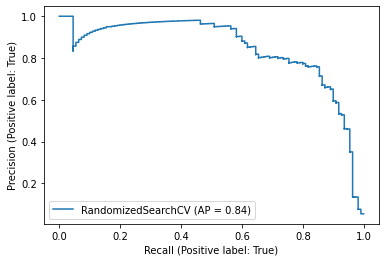

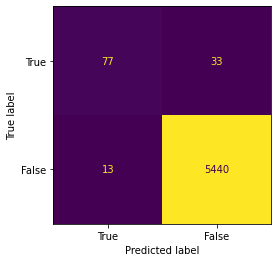

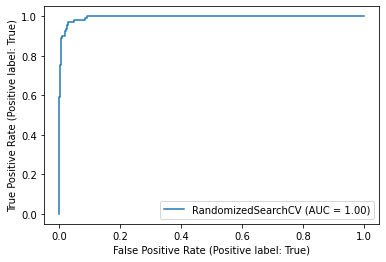

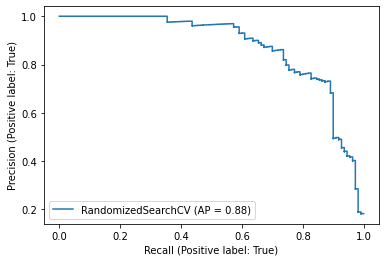

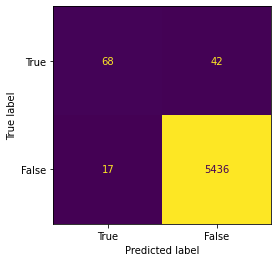

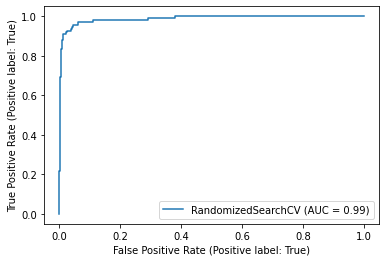

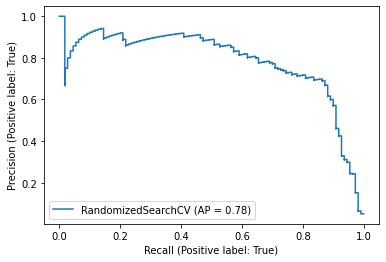

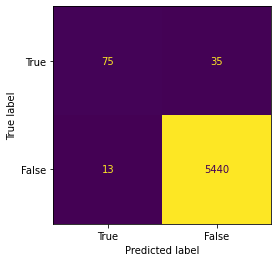

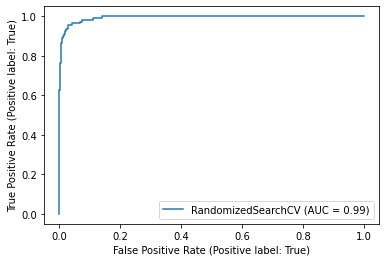

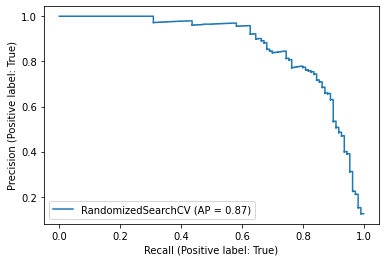

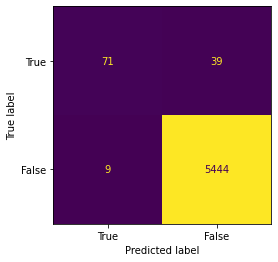

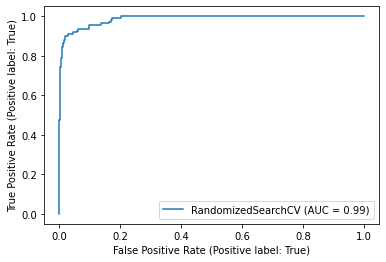

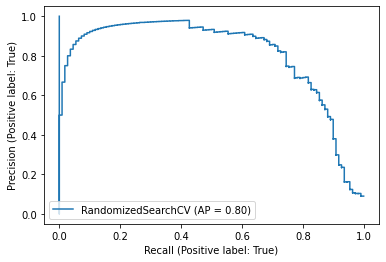

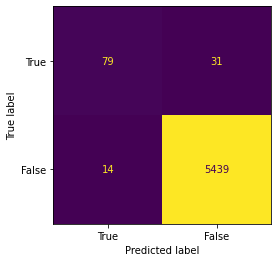

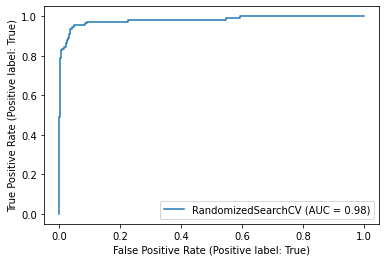

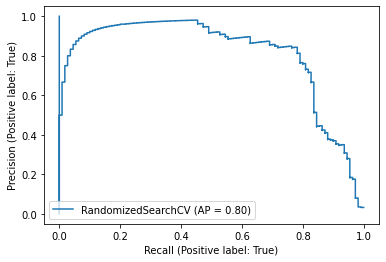

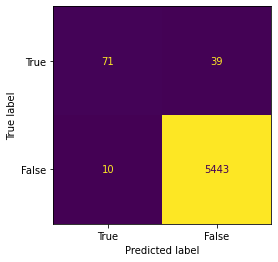

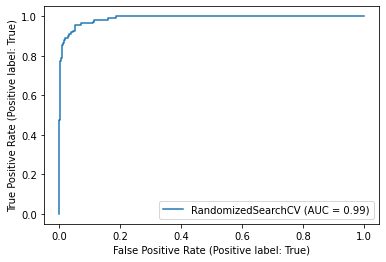

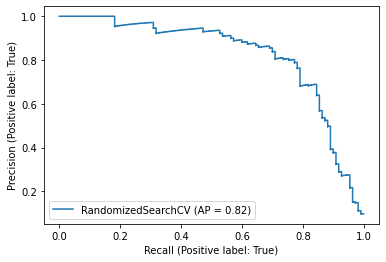

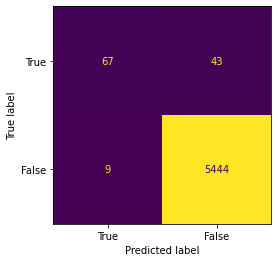

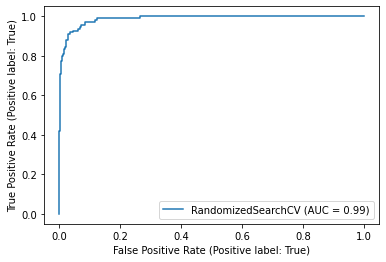

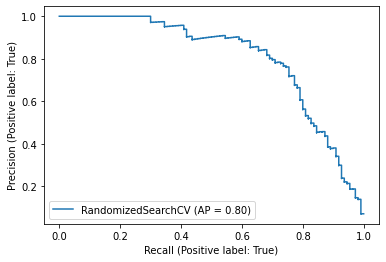

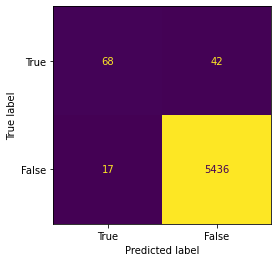

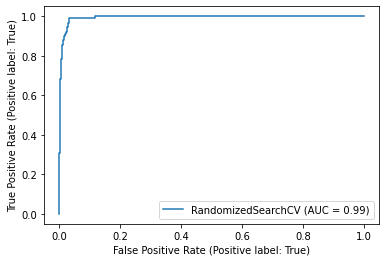

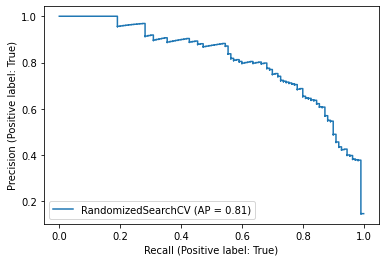

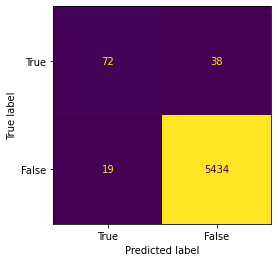

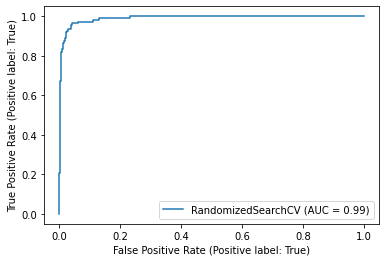

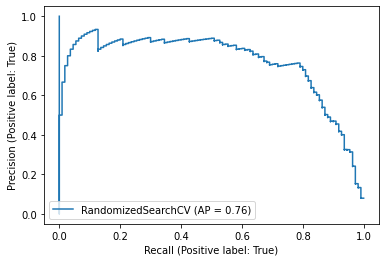

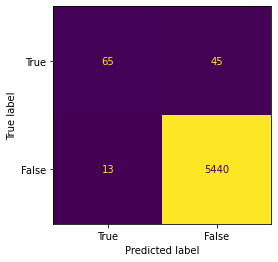

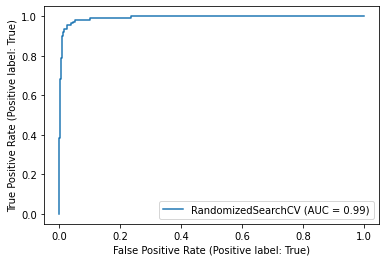

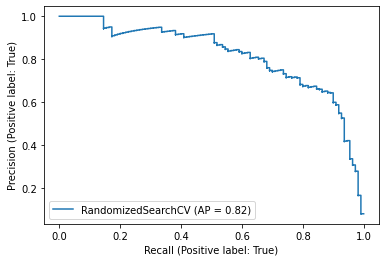

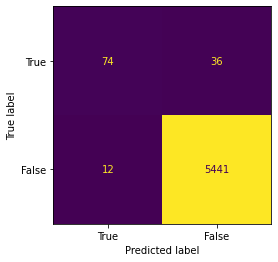

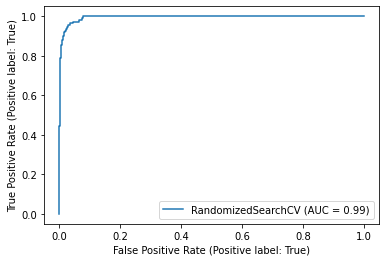

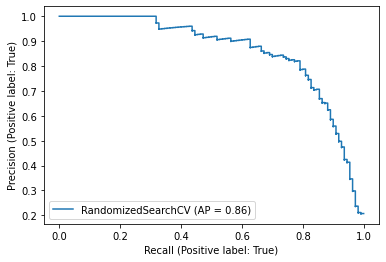

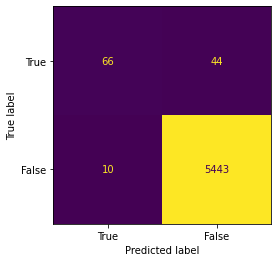

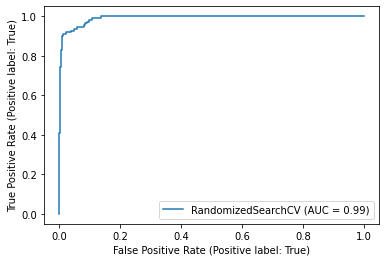

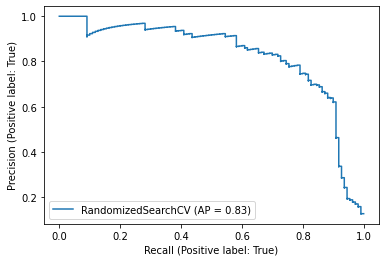

In [7]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)


for i in range(25):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                                   #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=-1)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                         testFeatures = X_test, 
                         testLabels = y_test)

# Model - Pipeline for Random Forests

In [612]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                             ['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]
spaceEmpty = dict()

search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.451 seconds


Cross-validation score: 0.2956041406141265
Test score: 0.2624203821656051
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall       F1        F2      F0.5  \
0  0.895919   0.152593  0.936364  0.26242  0.461883  0.183274   

   Average Precision  
0            0.14414  

--------------------------------------------------------------------


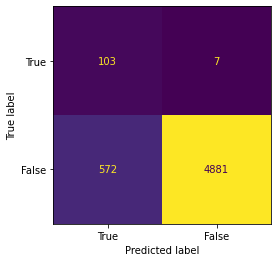

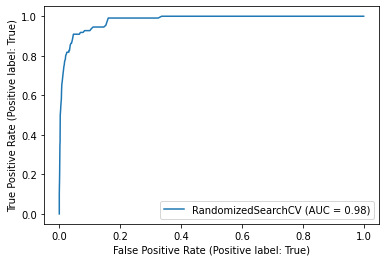

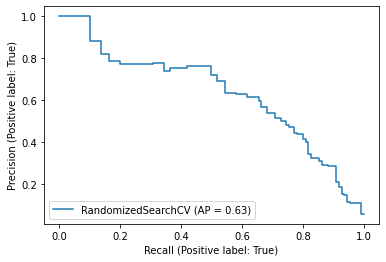

In [613]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.335 seconds
Cross-validation score: 0.30007522371917467
Test score: 0.27206946454413894
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.909581    0.16179  0.854545  0.272069  0.460333  0.193098   

   Average Precision  
0           0.141133  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.481 seconds
Cross-validation score: 0.29629236674922604
Test score: 0.28939828080229224
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.910839   0.171769  0.918182  0.289398  0.491245  0.205118   

   Average Precision  
0           0.159333  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.376 seconds
Cross-validation score: 0.289414197565662
Test score: 0.3
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall   F1        F2      F0.5  Average Precision
0  0.911918   0.177966  0.954545  0.3  0.509709  0.212551           0.170776

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.144 seconds
Cross-validation score: 0.2974268295766569
Test score: 0.3043478260869565
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.919468   0.183521  0.890909  0.304348  0.50308  0.218166   

   Average Precision  
0           0.165657  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.344 seconds
Cross-validation score: 0.3022900836612937
Test score: 0.31065088757396453
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.916232   0.185512  0.954545  0.310651  0.521869  0.221146   

   Average Precision  
0           0.177979  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.390 seconds
Cross-validation score: 0.2844193672186723
Test score: 0.30482115085536543
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.919648   0.183865  0.890909  0.304821  0.503597  0.218555   

   Average Precision  
0           0.165964  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.389 seconds
Cross-validation score: 0.3068973042425875
Test score: 0.3141025641025641
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.923063   0.190661  0.890909  0.314103  0.513627  0.226223   

   Average Precision  
0           0.172019  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.404 seconds
Cross-validation score: 0.2908098252598493
Test score: 0.31347962382445144
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall       F1        F2      F0.5  \
0  0.921266   0.189394  0.909091  0.31348  0.516529  0.225023   

   Average Precision  
0           0.173974  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.369 seconds
Cross-validation score: 0.30028351547750887
Test score: 0.26897470039946736
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.901312   0.157566  0.918182  0.268975  0.46716  0.188856   

   Average Precision  
0           0.146292  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.301 seconds
Cross-validation score: 0.2850524115899532
Test score: 0.29661016949152547
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall       F1       F2      F0.5  \
0   0.91048   0.175585  0.954545  0.29661  0.50578  0.209832   

   Average Precision  
0           0.168503  

--------------------------------------------------------------------


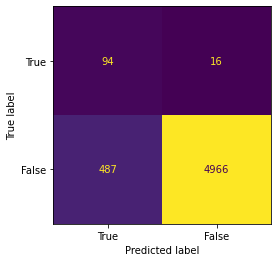

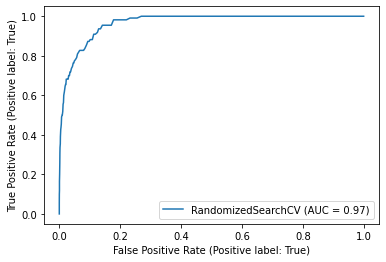

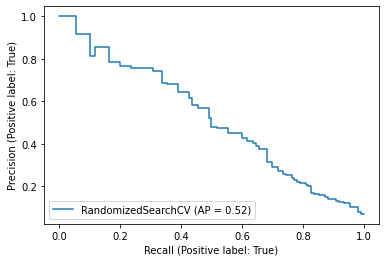

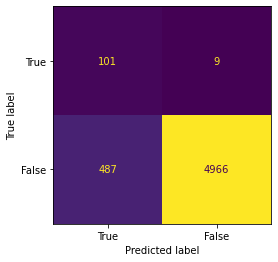

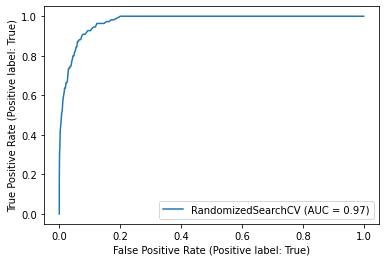

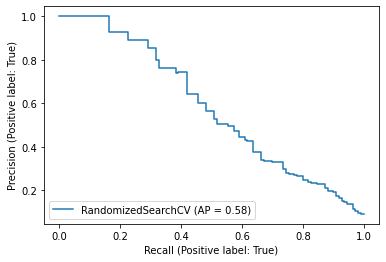

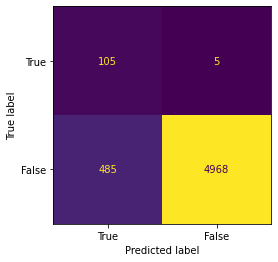

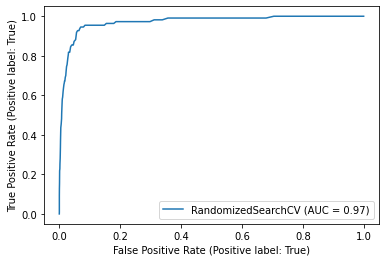

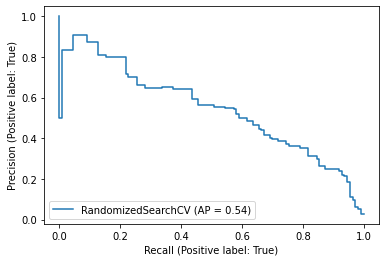

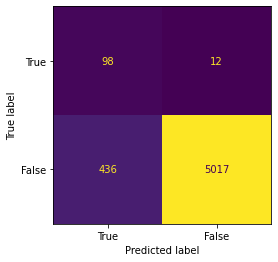

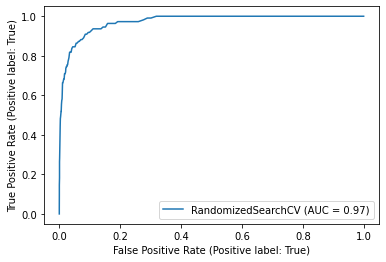

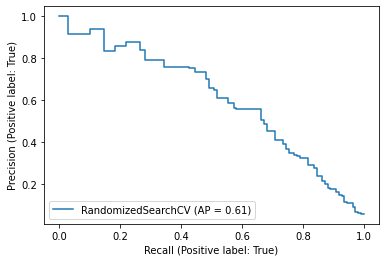

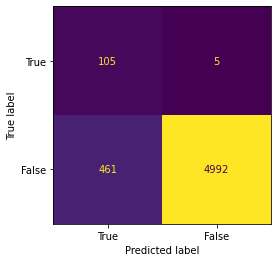

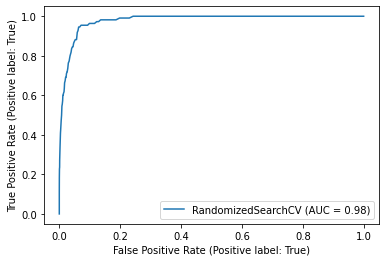

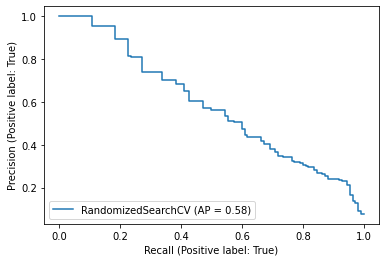

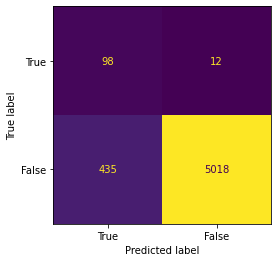

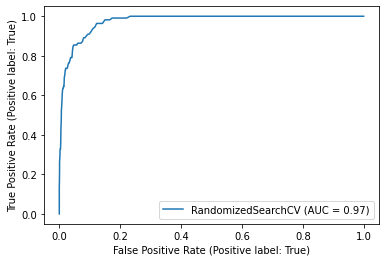

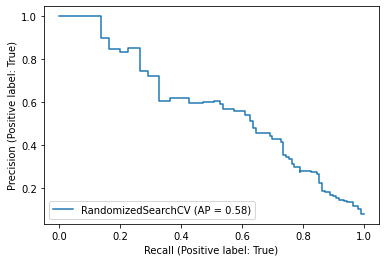

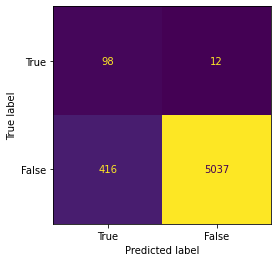

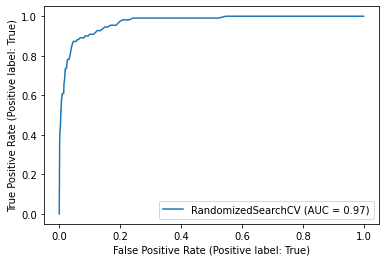

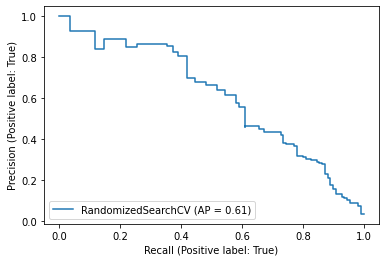

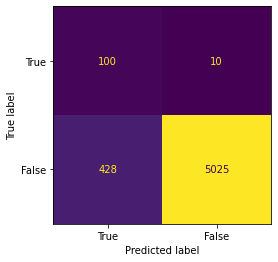

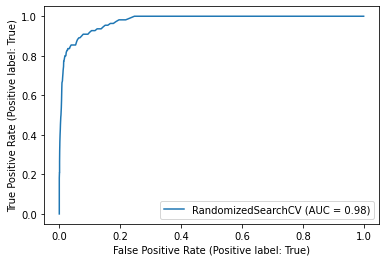

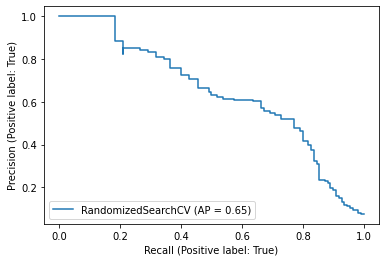

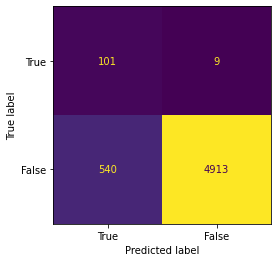

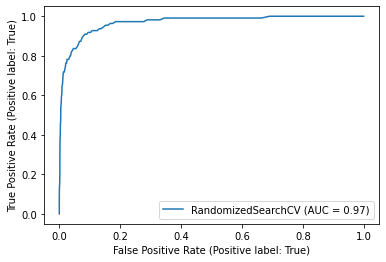

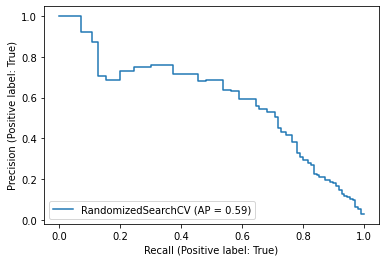

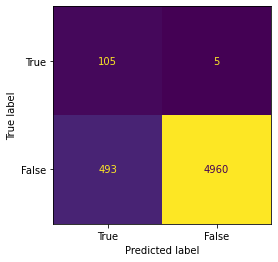

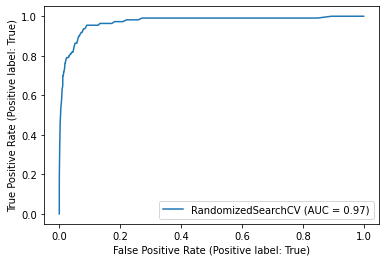

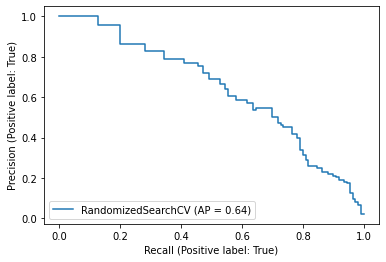

In [616]:
for i in range(10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        test_size=0.2,
                                                        stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                                 ['under', RandomUnderSampler()],
                                    ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict() 
    space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
    space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
    space['classifier__min_samples_split'] = [1, 2, 3]
    spaceEmpty = dict()

    search = RandomizedSearchCV(estimator = pipeline, 
                                param_distributions=spaceEmpty, 
                                n_iter=100, 
                                scoring='f1', 
                                n_jobs=-1, 
                                cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
          f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                         testFeatures = X_test, 
                         testLabels = y_test)

# Model - Pipeline for Light GBM

In [18]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]
spaceEmpty = dict()

LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.550 seconds


Cross-validation score: 0.5573708364126444
Test score: 0.5652173913043479
Best Hyperparameters: {}


Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.931332   0.216667  0.945455  0.352542  0.565217  0.256158   

   Average Precision  
0           0.205927  

--------------------------------------------------------------------


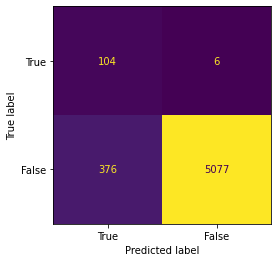

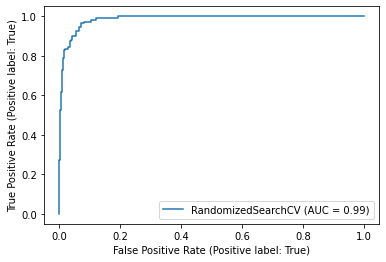

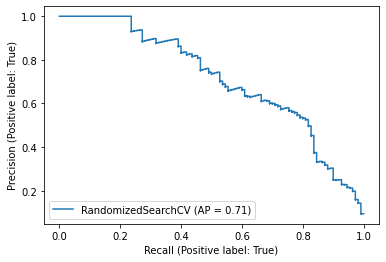

In [19]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)

display(eli5.show_weights(optimizedLightGBMModel))

#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76118439 0.69784697 0.7413652  0.74848409 0.77064089 0.77122996
 0.74921062 0.73710337 0.74303106 0.75830304 0.7727449  0.74734058
 0.75132884 0.75582267 0.75751416 0.74176324 0.75416714 0.75298441
 0.75812303        nan 0.7640712         nan        nan 0.76304313
 0.74015991 0.76321728 0.74052636 0.7683577         nan 0.75831039
 0.75964245 0.77022332 0.76485278 0.77352439 0.73399249 0.75062837
 0.74811518 0.74582881 0.78029691 0.74870479 0.73504129 0.74803507
 0.76470861 0.74845261 0.75279048 0.78142863 0.7728241  0.76409571
 0.75741137 0.75054204 0.73791435 0.74516933 0.76608754 0.77291782
 0.76115216 0.7384358  0.75243692 0.75264001 0.74500149 0.74341245
        nan 0.75907825 0.74472468 0.74805481 0.74454652 0.74765773
 0.77971964 0.7662462  0.75153025 0.76635323        nan 0.76201186
 0.74945451 0.76012906 0.74759344 0.75283258 0.76164923 0.75333324

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 879.283 seconds
Cross-validation score: 0.7814286348132576
Test score: 0.7975986277873072
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': -1, 'classifier__max_bin': 50, 'classifier__learning_rate': 0.1}
1213.39317715168
26997.069630920887
17906.728093594313
24495.591392695904
5379.941841244698
124.45589908957481
148.02451825141907
40.751213520765305
332.5148393213749
430.9603454172611
244.66785126924515
242.53717836737633
8777.046210676432
921.162948846817
114.05102676153183
0.0
526.8431482613087
0.0
33768.80926927924
135.90630331635475
3902.5613399744034
26.192888140678406
201.9742319881916
94.54100978374481
220.3240571320057
92.61530229449272
48.5585335791111
1620.2393243014812
1252.7473176121712
157.87144443392754
797.8581437170506
43.91488242149353
20.707197695

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.77224905 0.77846229 0.74834648 0.76328142 0.74973219 0.78733426
 0.76652417 0.77109941 0.75873928 0.76419524 0.77326859 0.76028373
 0.76911073 0.74666997        nan 0.75571998 0.77432574 0.78707975
 0.73152673 0.7653675  0.76158366 0.77626918 0.77489306 0.76861478
 0.74952767 0.74685221 0.77185874 0.77014712 0.77860864 0.75203788
 0.76616214 0.7513198  0.74861749 0.7712037  0.75519552 0.76076305
 0.75720115 0.75117637 0.7620563  0.76082109 0.75633227 0.77702722
 0.76372874 0.76467944 0.76016906 0.75218132 0.77172086        nan
 0.77322509 0.75669309 0.75704281 0.7482372         nan 0.76248847
 0.75607273 0.75899019 0.75903166 0.76884074 0.76238672 0.7605324
 0.77324069 0.7575133  0.77119175 0.7578264  0.75368433 0.77895437
        nan 0.77564418 0.75720459 0.75603831 0.76635069 0.77863716
 0.75312931 0.76936364 0.781051   0.77861444        nan 0.77050295


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 890.414 seconds
Cross-validation score: 0.7873342559396972
Test score: 0.7271095152603231
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 300, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.3}
208.8900812373904
8759.448344987914
9924.000157934053
15196.486814637583
3886.011316799705
143.50787309376756
163.38226875662804
15.651291981339455
112.99196627736092
41.430720537900925
47.99491564184427
95.47817144775763
1568.83130543679
79.01672537534614
100.69294612109661
0.0
257.23950372624677
0.0
3949.3360662193404
24.638351000377043
1637.468039125204
19.821598201990128
11.278695094075374
3.7226328998804092
92.3970159292221
44.12878741323948
87.66369221988134
1321.8568279030733
48.19396413748982
5.310489892959595
616.3876065015793
3.855360984802246
2.38916504

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75498579 0.73303231 0.77237151 0.74978345
 0.74444267 0.75130887 0.7403543  0.74554016 0.76603262 0.75274976
        nan 0.74576619 0.72948643 0.72949678 0.75775958 0.74537626
        nan        nan 0.74567298 0.73728554        nan 0.76021627
 0.75652651 0.76786885 0.73459337        nan 0.75632642        nan
 0.74839    0.7678483         nan 0.75849923 0.74032298 0.76741667
 0.73629196 0.76781036 0.76710775 0.74759621 0.75491502 0.74643948
 0.75567755 0.73696755 0.75393003 0.75487001        nan 0.73970739
 0.73178322 0.74738165 0.75282561 0.74300085 0.77583569 0.76648374
 0.73607944 0.74274156 0.74041279 0.75460291        nan 0.76968436
 0.74620162 0.75306052 0.75273497 0.75713431 0.76908163 0.74895181
 0.73429105 0.7350005  0.74140069 0.73286138 0.75575153 0.74767056
 0.75239272 0.76790656 0.73721707        nan 0.75883004 0.74420157

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 835.949 seconds
Cross-validation score: 0.7758356938077826
Test score: 0.7705779334500877
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 500, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.2}
437.4078097005224
13683.342124753395
14373.329519384395
17581.694888220376
6686.786129209765
90.68064451796755
12.295300369441975
39.47899302448877
307.03408411494456
32.896619379520416
92.20253783464432
2.15519442781806
3271.639014533721
599.9275119171361
47.16321964375675
0.0
364.15284788794816
0.0
7874.717080283113
240.14627236919478
1295.8847458810833
37.39264973340323
88.99557985924184
30.55581135619174
15.592559681273997
41.03320342488587
194.94922436773777
1283.972116365847
27.93376411497593
26.085559176193783
1.8608770817518234
13.603793919086456
11.349898

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76527498 0.75544465 0.76083544 0.77586773 0.75471641 0.7587137
 0.74917042 0.76320398 0.77220302 0.76705374 0.75902412 0.75366602
 0.77205337 0.75969533 0.73956546 0.73758944 0.76429925 0.75998657
 0.72468889 0.76035612 0.73577124 0.77339866 0.73356345        nan
 0.74512724 0.75638675 0.76462422        nan 0.75098974 0.75605804
        nan 0.75606557 0.76362862 0.76595191 0.77275631 0.73952723
 0.75145873        nan 0.74023094 0.75197177 0.7586498         nan
        nan 0.73959595 0.74426485 0.74597737 0.74013708 0.75708873
 0.75378536 0.75999029 0.75596368 0.76104646 0.74886049 0.76412979
 0.75572652 0.74977298 0.76296012 0.75357245 0.77364435 0.76235443
 0.74816983 0.74736775 0.75130745 0.7620792  0.77207692 0.76052677
 0.75255999 0.76973562 0.76080849 0.75662608 0.76100296 0.75344715
 0.7406198         nan 0.75972819 0.75636135 0.75405412 0.74065592


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 932.677 seconds
Cross-validation score: 0.7818478045884102
Test score: 0.769927536231884
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 100, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.4}
96.14736380268005
7492.131719322671
6927.983220898022
12525.471074936679
1675.2658437853388
34.346410844125785
25.592778718622867
0.18167191231623292
55.609625588636845
54.740527662681416
40.39976832258981
70.53361812443472
1139.2303529275814
844.6614735638141
44.19110430055298
0.0
26.127658756740857
0.0
4342.905245242437
25.80670340033248
1836.8624754110933
27.394496629131027
50.99248191213701
9.382692507118918
103.3103955576662
50.65247195138363
14.942692206939682
651.6221300528268
23.979282000975218
4.533037088112906
0.4316742685623467
0.0595591189339757
6.18743

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75483742 0.77715309 0.76681183 0.7608965  0.76751216 0.78044012
 0.76954735 0.77458603 0.7733118  0.76228885 0.79202062 0.77573422
 0.76136391 0.77869246 0.77372236 0.7650974  0.76894868 0.77240627
 0.75268652 0.76936346        nan 0.76093397 0.77488601 0.76082147
 0.77757361 0.77602806 0.7798865  0.79081099 0.76487863 0.77645556
 0.77837574 0.77923784 0.74912602 0.77036922        nan 0.74917243
 0.78253503 0.76101661 0.77983757 0.77397461 0.76649489 0.76866489
 0.7783499  0.77627683 0.76653347 0.76786353 0.75122958 0.76762636
 0.79377249 0.79336866 0.75699726 0.77651374        nan 0.75903346
 0.78905169        nan 0.76242234 0.77196132 0.76749016 0.7776859
        nan 0.77270079 0.78800784 0.77643596        nan 0.7737032
 0.75877962 0.77072946 0.76403287 0.76961423 0.78176624 0.77443973
        nan 0.76124095 0.76232745 0.75618774 0.76397704 0.77768156
 

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 1013.773 seconds
Cross-validation score: 0.7948970370428553
Test score: 0.6846846846846846
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 900, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.3}
166.4638839774749
9576.768986521189
9291.652037984251
15180.798840757578
3718.5263052217397
51.83296190536923
47.45570190285798
10.239702866392818
213.02574149452266
65.82252050895477
98.78382941204109
43.34986568929162
2419.2000312196033
562.5604439228025
8.331665728241205
0.0
274.83539564824264
0.0
2464.2635159359525
302.11338630653324
3903.184316426614
13.305205887882039
19.251061575370443
2.6090690416140205
22.60350317737334
9.614495752083414
28.69924793217797
523.3670306141794
714.7258940706961
67.8177731507476
248.9809883888811
14.525442361831665
12.0793331

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7790781  0.78553316        nan 0.76733835 0.7710075  0.77234366
        nan 0.76375418 0.76853889 0.76428481 0.77139872 0.78078
 0.7800795  0.78111    0.78576665 0.77839548 0.77223568 0.77237198
 0.78100535 0.7809942  0.79221274 0.77115678 0.77588472 0.76065022
 0.77958413        nan 0.78805745 0.75630422 0.78064389 0.7943632
 0.78725696 0.76824781 0.75380515 0.77563878 0.77915308 0.78382627
 0.78914329 0.79935763 0.77550484 0.75657174 0.78079236 0.7773749
 0.74144096 0.77800682        nan 0.77053015 0.76973736 0.80465322
 0.77174046        nan 0.78193629 0.77445307 0.76112152 0.78163428
 0.78390556 0.78978384 0.77183494 0.77381309 0.78059822 0.78959916
 0.78162006        nan 0.78627967 0.78696132 0.78378938 0.77277439
 0.77657961 0.77912472 0.77633654 0.76381967 0.78321117 0.7689387
 0.77108389 0.77004257 0.79311186 0.78578791 0.78433488 0.78694684
 0.77

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 1053.071 seconds
Cross-validation score: 0.8046532218831622
Test score: 0.7028469750889679
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': -1, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.2}
376.9907620359983
14429.477025060663
12621.943725323777
24118.14212539369
3166.1119661001353
24.050017292812342
16.43089232816419
12.491749637581961
161.69162974398836
19.576026316040952
97.78434350923635
23.342634698208535
2857.652432979768
898.2223222544515
23.751635909080505
0.0
147.38916932114523
0.0
5918.947401409353
28.29647973888683
2421.323597266714
12.126504818480592
94.65129347286302
8.951446843886515
43.010453375344696
62.42888450986152
208.95275771836168
907.15203105408
225.04263411890133
7.253185873928729
53.20050285913749
8.192770646951004
11.7180397

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75019572 0.76706125 0.75507336 0.7415376  0.74669928 0.75977357
 0.75090957 0.76446252 0.7815675  0.76764165 0.7701232  0.7638034
 0.75913862 0.74271819 0.75130475 0.76011757 0.76235186 0.76592603
 0.75951355        nan 0.77065684 0.76002175 0.75175075 0.76569842
 0.75530918 0.74009685 0.77800792 0.76150599 0.78495247 0.74151769
 0.76618714 0.77113427 0.77126273 0.77141955 0.759828   0.74576305
 0.75681083 0.77583932 0.78380576 0.7566967  0.7561457  0.74134461
 0.76762609 0.7871022         nan 0.74853654 0.7724859  0.77806118
 0.74080363 0.74696115 0.7723508  0.7637138  0.75864417 0.77177042
 0.76869576 0.76965615        nan 0.7608085  0.74735164 0.76994966
 0.76038679 0.76765657        nan 0.73608856 0.75817772 0.77216932
 0.73987996        nan 0.7507572  0.77403587 0.75333185 0.7438714
 0.73833692 0.74623655 0.775109   0.76247928 0.73084104 0.75607451
 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 968.951 seconds
Cross-validation score: 0.7871022047264102
Test score: 0.7820738137082601
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 900, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.2}
1077.607349516824
12056.552529036067
14497.803803544492
28878.110363721848
2542.6954378392547
112.91373035311699
152.67117173597217
14.767864923924208
765.0444461284205
179.7418981641531
158.2922867294401
116.98973322100937
1736.9449051097035
957.6175382435322
2.429675469174981
0.0
263.6113236621022
0.0
3164.1337330210954
80.94888558518142
2248.1392678134143
74.5530890673399
94.28584098536521
21.01811423152685
84.71369900926948
23.592732465825975
60.24085346516222
332.8337686881423
74.28867502696812
56.27073913812637
31.337041083723307
12.173397509381175
12.513899

C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.77149738 0.74425623 0.74467028 0.76116523 0.76425558 0.76846254
 0.74498085 0.75777673 0.77477456 0.75719951 0.77133205        nan
 0.75963521 0.74259179 0.7617556  0.76566793 0.72745001 0.7542924
 0.75735797 0.74796488 0.75183519 0.74093638 0.7570007  0.74241572
        nan 0.74024458 0.77582924 0.77805584 0.76672581 0.73195137
 0.76185465 0.76279009 0.75217852 0.74867288 0.76918748 0.76397947
 0.74890407 0.7711074  0.74885526 0.75197409 0.75615959 0.74979339
 0.75442378 0.74979074 

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 876.255 seconds
Cross-validation score: 0.7780558435680385
Test score: 0.7547169811320755
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 500, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.2}
197.64527070522308
14062.36917078495
11594.313123524189
17622.28824532032
3263.6240199804306
81.7969981431961
11.311389923095703
8.922329902648926
547.0805417895317
147.4926302433014
121.42718696594238
54.83826971054077
5373.063508987427
495.36785769462585
148.2415030002594
0.0
74.06311845779419
0.0
5937.942844152451
438.39974343776703
4162.33373105526
5.217050075531006
161.24945092201233
23.732150077819824
21.157360076904297
15.154250144958496
87.25894927978516
1914.0027627944946
5.531919956207275
16.14579963684082
0.0
15.047599792480469
12.973440170288086
146.37

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73539861 0.75754958 0.75334162 0.73963652 0.76056047 0.74015877
 0.75718295 0.76479644 0.73994801 0.74647932        nan 0.74599309
 0.76727949 0.76028015 0.75468309 0.76731062 0.77434167 0.75937875
 0.75897381 0.73685842 0.75708421 0.76005111 0.75530031        nan
 0.75482572 0.75919353 0.76844559 0.76929728 0.75869435        nan
 0.77304543 0.75888361 0.75283517 0.76929124 0.7476864  0.77103255
 0.76843415        nan 0.73926242 0.76239062 0.75863906 0.75774208
 0.75913636 0.76726124 0.76323244 0.77748888 0.75450748 0.76680471
 0.75540701 0.75010556 0.75057809 0.75295913 0.75099548        nan
 0.7563166  0.75021883 0.76116225        nan 0.75930093 0.77083849
 0.77035824 0.758632   0.76953152 0.75456473 0.75897203 0.76170902
 0.7662421  0.75923824 0.76922916 0.76415866        nan 0.76025947
 0.76457987 0.7499142         nan 0.74713181 0.73986963 0.7726928


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 805.816 seconds
Cross-validation score: 0.7774888750046622
Test score: 0.72992700729927
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': -1, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.3}
48.02828149497509
9155.051841527224
8385.008100777864
13315.189372062683
4128.574685424566
37.095245108008385
5.127729117870331
20.644091427326202
346.5490528643131
47.79309257864952
154.40984892845154
6.5067970007658005
2438.296104684472
146.7084041684866
11.004799842834473
0.0
216.11519028246403
0.0
2337.8282098025084
13.238457903265953
5136.154465660453
5.724570870399475
350.1395900994539
20.437212124466896
33.45570167899132
82.36834713816643
61.98269322514534
746.4719740748405
0.3414050042629242
16.374878525733948
25.48240089416504
0.0
1.5825459957122803
272.9891

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7378994  0.77072514 0.75199809 0.75264233        nan 0.74228311
 0.73574378 0.75011559 0.75003162 0.7729956  0.74933292        nan
 0.7522963  0.76216049 0.75689806 0.73177149 0.7388999  0.77262312
 0.7605678  0.76553926 0.76553003        nan 0.75527526 0.76008875
 0.75727234 0.76343601 0.74289154 0.76595884 0.75017174 0.74995685
        nan 0.73601893 0.74669937 0.75336031 0.75546513 0.75830978
 0.73915121 0.74225822 0.74231505 0.75479064 0.75548463 0.75596476
 0.7526695  0.75465426 0.73642237 0.75536587 0.75939473 0.7539486
 0.75442925 0.77736001 0.74784035 0.74534614 0.75999226 0.74248042
 0.75576073 0.75341873 0.76424302        nan 0.76710265 0.71860967
 0.75867974 0.76784024 0.75361749        nan 0.75563253 0.7362753
 0.75736363 0.74915483 0.75052147 0.73114907 0.75183602 0.75659599
 0.75760008 0.7493396  0.75406115 0.75278582 0.74862428 0.75573296
 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 828.334 seconds
Cross-validation score: 0.777429500758221
Test score: 0.7586837294332723
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 400, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.5}
627.2221272352544
5842.312042072677
5200.611689481968
9914.920710918177
3197.4818468494122
54.56064917366166
83.52520897761133
42.26871597102581
570.4783386382478
32.464966096536955
127.97937034722418
78.96503173752717
1910.9802142938788
167.23399837708712
48.40625486720819
0.0
33.17976716245903
0.0
2678.0080966348687
106.82178502858005
1081.1201487250873
22.837410850268498
14.739861303503858
0.674999861366814
11.419575652500498
19.290774788474664
174.32666921883356
43.40705737355893
0.06528391037136316
26.923855748493224
150.669128576621
21.752348113805056
4.70477

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.74693462 0.7389811  0.75906263 0.74383734 0.71663268
 0.7373769  0.74474038 0.74041184 0.75306432 0.74881102 0.72936608
 0.74904967 0.71786649 0.74473798 0.75765346 0.74184606 0.72465601
 0.7136674  0.73321687 0.73152563 0.73655282 0.71563223 0.75294743
 0.73990951 0.72733559 0.70097013 0.75943926 0.75709453 0.71633893
 0.75589417 0.72560581 0.74445111 0.73359621 0.74619043 0.74661481
 0.7406721  0.74209557 0.72456817 0.73407471 0.73934671 0.73387906
 0.74448982 0.74323289 0.73758721 0.75172552 0.72644945 0.72874695
 0.76302057 0.70825539 0.73771478 0.71890518 0.74859674 0.75087897
 0.73490243        nan 0.74204801 0.72361366 0.72738185 0.72796224
        nan 0.74014855 0.72242415 0.74567356        nan 0.73236976
 0.73707892 0.72807835 0.74110731 0.74042777 0.74745338 0.7535175
 0.73800307 0.74372431 0.74154774        nan 0.75535428 0.75851339


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 927.316 seconds
Cross-validation score: 0.768221844547316
Test score: 0.7982456140350878
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 800, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.1}
707.9303468118887
25525.744244309142
23086.249973788857
39555.50927916728
6361.738433107908
84.36851947568357
88.50636911392212
79.14168447256088
640.2453429661691
55.09505753964186
18.619122879579663
130.91822761297226
5189.992319360375
914.8600475788116
247.70913553237915
0.0
973.0449738129973
0.0
17688.553661460057
150.85047306865454
2590.445499755442
71.0497495830059
171.95514551573433
149.12577728927135
50.98988148570061
19.452203527092934
136.04056047694758
1543.5915262810886
659.0917045976967
108.02983843930997
154.58854484558105
44.323498487472534
21.941950

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73737918 0.75051136 0.74879953 0.76725111 0.75978514        nan
 0.76210978 0.75005377 0.75765296 0.74191311 0.75095016 0.74687244
 0.74074954 0.72965649 0.74889509 0.76611147 0.75183946 0.73068665
 0.75720963 0.74780151 0.73961112        nan 0.75804165 0.75876996
 0.75452679        nan 0.75079639 0.75386777 0.73647527 0.7473734
 0.75709774 0.73960699 0.76641766 0.74764495 0.73079883 0.75567282
 0.75222981 0.74686468 0.74410739 0.729973   0.75477234 0.7431852
 0.75648857        nan        nan 0.75436161 0.7401287  0.75543242
 0.75694393 0.72312841 0.7084894  0.7411908  0.76712901 0.74388379
 0.76051151 0.74727977 0.77133839 0.74620662 0.7560974         nan
 0.75980881        nan 0.74025415 0.74736068 0.73366809 0.7612644
 0.74372565 0.7587733  0.73096503 0.75676284 0.75347453 0.7585547
 0.74566293 0.76192513        nan        nan 0.77079391 0.75997266
 0.

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 857.981 seconds
Cross-validation score: 0.7713383863198754
Test score: 0.7837837837837838
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 100, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.6}
53.77477713013832
3986.7453015338106
7518.217432206206
9147.400111228897
3026.52361257295
12.926664299418917
11.51329070702308
0.1233185505552683
35.91507577570155
0.3744950865908771
0.674387888982892
31.79958775729756
1460.3957630846521
148.50899052899535
5.287124045426026
0.0
29.75947341363781
0.0
1989.790193385486
20.086264463035832
629.2615212001838
1.8733691868110327
6.406178067773851
16.62460665742401
86.20368092936087
3.4988007287029177
1.2123443817836232
303.0028800875298
48.663021818734705
2.3069761847145855
0.23986114754551124
17.202802636427805
4.682845

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73181427 0.75706473 0.74989199 0.75117967 0.74559514 0.75059999
 0.74613936        nan 0.75861925 0.74624563 0.74983869        nan
        nan 0.73857054 0.75177484 0.75677265 0.74268204        nan
 0.75373903 0.76143429 0.74569271 0.74847611 0.75764301 0.7624621
 0.76684187 0.7482018  0.75917338 0.77661066 0.75181272        nan
 0.74861415        nan 0.75489866 0.75807113 0.73678666 0.75671334
 0.76542639 0.74847501 0.74744498 0.7373095  0.75037409        nan
 0.75139799 0.75265855        nan 0.74609595        nan 0.7542225
 0.75749481 0.76260086 0.74817283 0.76177779 0.72814073 0.76101158
 0.75400382 0.75776505 0.74841507 0.75867737 0.74710952 0.74859652
 0.74892511        nan 0.75672286 0.73305276        nan        nan
 0.73582179 0.75875441 0.76539964 0.75847017 0.75196206 0.7413161
        nan 0.75124578 0.76253041 0.74993168 0.76005791 0.75105871
 0

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 873.574 seconds
Cross-validation score: 0.7766106611268546
Test score: 0.7946428571428571
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 300, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.2}
500.3793072551489
15503.951076120138
10882.284945197403
15918.203206788749
4656.7188623435795
57.89630661532283
306.694844994694
23.397386759519577
670.0567840076983
35.763499442487955
98.26627999916673
19.03212121129036
1731.2651956230402
915.4595254920423
18.66629609465599
0.0
356.34723261743784
0.0
11634.852064434439
101.34619060531259
3452.5364047549665
19.34706872701645
20.52829896658659
38.47786822915077
42.33350884914398
27.184328380972147
207.64482226967812
621.9785247221589
711.0631678029895
15.701473653316498
449.42057529091835
6.756701111793518
5.669206

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7399398  0.7393779  0.75181973 0.73611157 0.73088595 0.75183508
 0.7400553  0.71743636 0.75621425        nan 0.7506604  0.74981567
 0.72807317 0.74894263 0.72856498 0.73163309 0.73327246 0.74872676
 0.74983191 0.75148302        nan 0.73898609 0.74753595 0.73658596
 0.71859876 0.74622552 0.74055329 0.72862487 0.7385386  0.73156559
 0.74611283 0.75493665 0.75313663 0.72000566 0.7453987         nan
 0.75078534 0.73657856 0.760859   0.75875702 0.75466648 0.74790472
 0.7576954  0.74452774 0.75840884 0.74557624 0.72572158 0.75317981
 0.75218168 0.74376272        nan 0.75276564 0.75132894 0.75976135
 0.75080961 0.75146201 0.74331297 0.73905237 0.7272676  0.7454194
 0.74514887 0.745175   0.74840239 0.74146335 0.7622233  0.73413225
 0.74394754 0.76177228 0.75335018 0.74595537 0.74313151 0.73981983
 0.74813418 0.73113241 0.73768857 0.74050236 0.73081804 0.72492778


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 960.982 seconds
Cross-validation score: 0.7622232963533995
Test score: 0.8078231292517007
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 200, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.1}
415.66060596704483
21583.77308790802
28323.001241094666
38968.67736136052
7571.20852402132
12.125515542924404
61.31546548753977
11.781280040740967
650.704852104187
90.07192993164062
187.19873070716858
24.71340411901474
6348.407913200557
1131.4086582208984
125.66016656160355
0.0
497.6633353829384
0.0
9904.829173996288
14.974050968885422
6210.60165688589
26.59670801833272
121.33102063741535
38.0199918076396
99.9158426199574
15.12837028503418
110.83813481032848
3702.798429493414
1.7627587541937828
7.53587007522583
307.365634560585
44.49211025238037
12.166947962716222

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76962944 0.77749499 0.75903434 0.74308397 0.76979416 0.76489429
 0.74562908 0.76776487 0.77977387 0.76290008 0.75322143 0.77635449
 0.76941681 0.741539   0.76876733 0.76212395 0.77055769 0.75869788
 0.74087644 0.77037851 0.77368878 0.77530117 0.78198438 0.75350163
 0.76536712 0.77053242 0.77505639 0.768974          nan 0.75527924
        nan 0.74568295 0.76947454 0.77225437 0.78724631 0.74993713
 0.77129444        nan 0.78343883        nan 0.77759964 0.76247972
 0.77756854 0.76654012 0.76444383 0.76239282 0.77762953 0.74372391
        nan 0.76441605 0.78761064 0.77084976 0.74983243 0.7724092
 0.7370087         nan 0.75516722 0.7813062  0.74481323 0.75929327
 0.74435466 0.76840631 0.75229796 0.76752395 0.77017415 0.77396781
 0.784835   0.75400996 0.75508215 0.7751486  0.73943943 0.77500281
 0.7633358  0.74441644 0.76973796 0.74886247 0.75659931 0.75404447


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 951.752 seconds
Cross-validation score: 0.7876106362979539
Test score: 0.7246376811594204
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 300, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.2}
237.57835959918646
16098.559991507425
9164.9984589416
21581.381829275135
1520.3637174285063
238.80193851169335
51.09901468617318
20.651214899896786
165.9593024100891
39.2026789165684
270.44877740734955
24.75783678146672
1568.178229789055
771.8461761699523
16.927052582709848
0.0
232.9727816280556
0.0
6255.759051982327
152.64634448019072
3355.2582621100287
19.38570076595423
327.5460296016063
10.62862127457629
52.29905150413106
25.531013589773465
34.61474611603444
4301.1791995211415
326.185866951615
205.81592639953305
209.77266995771788
21.699762702010048
10.12386492

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73679658 0.7524584  0.73198395 0.75873861 0.7669097  0.75550973
 0.74594265 0.73955442 0.73113674 0.75399348 0.75763426 0.75934827
 0.75727175 0.75163108        nan        nan 0.73196327 0.76292135
 0.75472224 0.75170286 0.76013181 0.750553          nan 0.7631209
 0.74435737 0.74828053 0.74663784 0.73536509 0.75991126 0.75462986
 0.72452455 0.73990876 0.75914563 0.74067643 0.75631036 0.72970526
 0.74665516 0.76201671 0.74364217        nan 0.7291117  0.75102153
 0.7674009  0.72318613 0.75052265 0.75536856 0.75704964 0.73949532
 0.74275198        nan 0.7665182  0.73319896 0.7399253  0.76933666
 0.75222654 0.75299283 0.73759123 0.75827698 0.73764497 0.75963436
 0.75115746 0.7494728  0.74933181 0.74322139 0.75017176        nan
 0.75679436        nan 0.73635683 0.75640238 0.75338977        nan
 0.73642733 0.76028354 0.74652882 0.74832345 0.73648431 0.73568356


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 930.494 seconds
Cross-validation score: 0.7693366589019909
Test score: 0.8053097345132743
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 100, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.4}
151.40734034962952
7880.68117122259
6057.1869440395385
10376.945997229777
3859.335512764752
44.65993099659681
66.78186300955713
11.732788145542145
545.2131765764207
14.828307460993528
150.2508474048227
7.069125443696976
2727.1228758785874
139.155800960958
135.26461688056588
0.0
270.882425468415
0.0
2220.048476483673
26.915326841175556
1418.4414214994758
9.15337105281651
25.467364843934774
10.994369560852647
10.001342937350273
11.02942705154419
249.54428645968437
606.1510393358767
13.328171983361244
102.58114916086197
305.2755402736366
3.1918965354561806
4.14414485

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74603018 0.74320953        nan 0.7338543  0.74576459 0.77388344
 0.769935   0.74248808 0.74928824 0.74729614 0.75599542 0.74101435
 0.74993981 0.75783803 0.72479244 0.76409472 0.74992942        nan
 0.76305583 0.74329741 0.75588939 0.75688538 0.75634529 0.75111104
 0.75487141 0.72634723 0.75916991 0.75414277 0.76165051 0.76672022
 0.76079165 0.75469016 0.74867204 0.74766502 0.76282932 0.75761401
 0.75049396 0.76116423 0.74186481 0.7621185  0.76317011        nan
 0.74481522 0.75835767 0.74393351 0.75518675 0.7578066         nan
 0.75401024 0.76574383 0.76033653 0.76133992 0.74218131 0.74374223
        nan 0.73616227        nan 0.75013399 0.76519091 0.76096012
 0.74332757 0.77799782 0.7606033  0.73872914 0.75692087 0.73569425
 0.76000348 0.75321285 0.73873966 0.74670927 0.76081956 0.75393943
 0.76365439 0.77461815 0.74297448 0.73352664 0.74916449        nan

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 844.190 seconds
Cross-validation score: 0.7779978185742117
Test score: 0.737410071942446
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 700, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.5}
557.4604992446257
6657.666198436345
6343.500815698295
8994.095472802117
494.56898554298095
40.94426728494
3.574464501347393
17.004347468027845
44.21422635274939
47.82824148226064
192.38930371869355
9.213593470165506
1205.2896079054917
510.15160298586125
34.255071519874036
0.0
80.41936054709367
0.0
3439.1148183771875
16.296975343488157
1695.365697096102
4.077788443537429
13.200447410810739
57.13143818755634
3.433830439229496
3.7217356838518754
21.16249776945915
1719.1220119028585
324.6771603364614
11.198846295592375
36.31756476312876
0.004616810008883476
1.345019233

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7432669  0.73174776 0.73553661 0.75042843        nan        nan
 0.72955806 0.75058183 0.7531832  0.75268364 0.76854225 0.74785002
 0.76505011 0.74180749 0.72216909 0.73149015 0.75991356 0.76348826
        nan 0.74741889        nan 0.74506741        nan 0.75031489
 0.73263271        nan 0.74994514 0.75104954 0.75274592 0.73971431
 0.74501964 0.76534342 0.73322658 0.7632481  0.76600491 0.74841751
 0.73784126 0.75399037 0.7572354  0.76206037 0.76607411 0.76522391
 0.73318781 0.76823367 0.74852894        nan 0.75271902 0.75533842
 0.76699612 0.7436909         nan 0.74238238 0.73633381 0.76025196
        nan        nan 0.74831825 0.72646753 0.73623309 0.72238491
 0.75919967 0.73796247        nan 0.76145684 0.75131726 0.74406007
 0.7599616  0.76693304 0.75251237 0.76966641 0.7478074  0.75935859
 0.76914426 0.75739982 0.7229084  0.74799728 0.73677373 0.74474135

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 827.076 seconds
Cross-validation score: 0.7696664149046689
Test score: 0.7651245551601424
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 300, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.4}
67.22259841696359
6128.416219544684
8704.019675131189
10011.379788229242
3358.032578983868
10.002024161629379
29.832964400295168
1.767660197801888
137.68109029816696
3.9070545935537666
120.20594093226828
21.763805378926918
1354.383172732545
268.71246091410285
12.766718034632504
0.0
297.7219767834322
0.0
4667.625929210102
21.566144762560725
747.7747323174626
35.477709426311776
21.005709485849366
12.465545498766005
10.770027806749567
24.248493973980658
15.858722422737628
1110.7484261116479
343.39757251087576
19.202373525477014
0.7017127759754658
6.190093015087768
6.

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75736868 0.7602934  0.75166523 0.76851691 0.76493311 0.7539111
 0.75856256 0.74499242 0.75811461 0.75712218 0.7525106  0.76408079
 0.77255102 0.76697609 0.74559639        nan 0.75381191 0.76974013
 0.74567131        nan 0.7438461  0.73859576 0.75618295 0.75485608
 0.73928291 0.75448374 0.75981634 0.75820009 0.7256605  0.7761932
 0.76390428 0.75505809 0.7485368  0.74804273 0.7486219  0.73274858
 0.76313313 0.76956909 0.73630073        nan 0.77017752 0.77204931
        nan 0.76370848 0.77261349 0.77029135 0.75231654 0.76414824
 0.74676753 0.74016397 0.74498801 0.75680901 0.76415461 0.76082479
 0.75710142 0.74973996 0.75383347 0.73959968 0.77086527 0.75316677
 0.74863761 0.73013545 0.75813343 0.7618159  0.76911069 0.75424067
 0.75305543 0.75185084 0.75894225 0.74887432 0.74125399 0.77739811
 0.7638766  0.77702921        nan 0.72872688 0.75671904 0.75191547
 

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 943.350 seconds
Cross-validation score: 0.7773981113945647
Test score: 0.7456140350877193
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 300, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.1}
146.37356609106064
24338.679717570543
23948.474011957645
40548.634773254395
6379.105147600174
104.31111907958984
84.17657041549683
43.311930418014526
309.0399570465088
60.79490041732788
956.1552734375
162.71448040008545
7038.08465886116
1018.1741373538971
106.2070426940918
0.0
533.382763504982
0.0
9889.03406715393
326.4426894187927
4538.056665658951
22.594080209732056
61.17169165611267
0.0
243.2334268093109
151.65923929214478
262.0335810184479
3069.260249376297
742.4539794921875
34.311949729919434
488.9989929199219
57.49809980392456
7.989739894866943
591.298505425

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76045142 0.74336915 0.76360551        nan 0.77848611 0.76763528
 0.75577653 0.76732381 0.7569326  0.7580235  0.76784021        nan
 0.74915703 0.76339869 0.76661345 0.75923551 0.75130365 0.76465394
 0.761108   0.7613359  0.77308382 0.75534435 0.76508244 0.76465904
 0.75368268 0.75387    0.7366248  0.76789008        nan 0.76404308
 0.74158371 0.76334074 0.74975124 0.75104858 0.73793785 0.75616472
 0.75266908 0.72617014 0.77315168 0.76053698 0.75932865 0.7483294
 0.77513057 0.74950826 0.7637727  0.74856203 0.76614085 0.73966399
 0.77059509        nan        nan 0.75102981 0.76645217 0.76006238
 0.75053798 0.74664263 0.75173814 0.75141522 0.77374341 0.75707914
 0.75977656 0.75578802 0.75835011 0.76564902 0.76274507        nan
 0.72563503        nan 0.76464399 0.74467459        nan 0.76708814
 0.78299131 0.7722763  0.75992294 0.75958792 0.75271321 0.75032428


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 932.235 seconds
Cross-validation score: 0.7829913129432652
Test score: 0.7705779334500877
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 800, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.2}
503.53654643148184
16048.137849993072
11453.626001955941
19440.131915293634
4539.810506455688
181.70229610428214
103.62627160549164
12.396848261356354
258.84066320210695
17.72942914068699
150.32912646397017
89.60138416290283
3387.454396562651
462.87103541754186
98.6601151227951
0.0
320.07138638943434
0.0
7365.072204310447
116.1487614698708
1584.6007845001295
85.62439227104187
28.435487017035484
6.317295283079147
46.69336250424385
122.22686462849379
119.09024128317833
1843.742940178141
9.450595065951347
14.004234954714775
183.0853254236281
8.89461188018322
14.58232

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75763064 0.76997392 0.76097212 0.74865977 0.71988523 0.74804668
 0.75448593 0.75949545 0.74366396 0.73686625 0.73614323 0.78126283
        nan 0.77736787 0.7527206  0.75313591 0.75751933 0.76824155
 0.74821995 0.74921831 0.7509811  0.75853194 0.7602257         nan
        nan 0.75254093 0.76482451 0.77288604 0.74813209 0.76412381
 0.76623188 0.76140372 0.74688701 0.74344713 0.74424878 0.74685294
 0.76424225 0.75554036        nan 0.74009701 0.74189519 0.73864597
 0.75824908 0.76709418 0.767143   0.75734707 0.74478438 0.767115
 0.75339976 0.75312912        nan 0.75216317 0.74901934 0.77688075
 0.72080057 0.7357736         nan 0.73520982 0.76063748 0.76238415
 0.76830856 0.7522646  0.75672813        nan 0.75468103        nan
 0.74675786 0.75517149 0.76836826        nan 0.73537244 0.74985069
 0.76136907 0.74879721 0.774404   0.7587943  0.7410265  0.74086103
 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 905.065 seconds
Cross-validation score: 0.7812628317616569
Test score: 0.7221206581352833
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': -1, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.3}
162.96444511413574
10540.782673723887
7162.5938025249925
13882.543243227701
2971.706573280967
33.726721579398145
49.48802498287114
2.4321694544923957
520.2000410679684
134.32921996922232
124.05421520984964
75.52892464473553
1290.814959144278
364.30253788143
77.6040327619412
0.0
157.41150365948852
0.0
7711.612631807131
68.26020494528348
1019.5938938914624
13.219444651185768
366.1636675575355
47.917915521829855
16.37469039001735
28.772616833937818
218.40551375672635
812.8476083164569
475.73446515845717
5.0216157586546615
305.3446593476401
0.4403645112470258
5.9255990

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74610609 0.74369057 0.72932524 0.74432121 0.74687397 0.72131478
 0.74587115 0.73533998 0.74082359 0.70709406 0.70889925 0.73953191
 0.74844317 0.76353254 0.72257998        nan 0.7435666  0.73996033
 0.73137383 0.72264991 0.73339342 0.74230082 0.77223152 0.75967129
 0.75513174 0.73966454 0.75321179 0.75855173        nan 0.74324484
 0.73210098 0.74285199 0.75616212 0.74860872 0.73606087 0.74183231
 0.75487762        nan 0.73506683 0.75116275 0.75030972 0.73612127
 0.72953732 0.75772155 0.7480425  0.73967716 0.73194605 0.73602113
        nan 0.73832415 0.74255782 0.74451151 0.75679679 0.73260811
 0.73738757 0.73899139 0.73270835 0.72212447 0.73317121 0.74991654
 0.74147517 0.71487052 0.74596292 0.75079923 0.73557059 0.75079119
 0.73558367 0.76925766 0.75114915 0.75112711 0.7422879  0.71800357
 0.7617573  0.75165043 0.7365227  0.7562343         nan 0.76157858

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 872.540 seconds
Cross-validation score: 0.7722315233235488
Test score: 0.7739130434782608
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 100, 'classifier__max_bin': 50, 'classifier__learning_rate': 0.1}
534.3319840431213
23337.792853754712
24408.33907363462
29756.95706719905
3991.199960277654
23.331463368900586
218.4750943183899
40.2221457362175
452.6656093597412
81.23849004507065
455.24046446965076
57.417394177173264
5147.409094715724
2434.4520490668947
58.98808014392853
0.0
212.50525146350265
0.0
20002.8417787869
80.48475002621126
12654.076304226706
3.598970018327236
265.82238456606865
145.24173665046692
13.42490005493164
10.721800697036088
219.825603723526
1998.0075796842575
690.9032459688606
53.812899589538574
127.1395697593689
36.10281676054001
5.059866115450

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73102754 0.73507104 0.75260619 0.73533689        nan 0.75104324
 0.72983255 0.75522612 0.74167686 0.75248931 0.7238301  0.75290832
 0.75119322 0.74611299 0.74134289 0.76003039 0.71149821 0.72312942
 0.7492979  0.74776214 0.74904247 0.71840994 0.75890688 0.73463401
 0.75741949 0.75998386 0.74866576 0.71502433 0.73296749 0.73780961
 0.72905677 0.75285843 0.72780085 0.74773994 0.75592494 0.73407602
 0.74728371 0.74496361        nan 0.75650359        nan 0.74602235
 0.7541806         nan 0.7325344  0.74279803        nan 0.72475925
 0.75017765 0.74135331 0.73431481 0.74377618 0.73974266 0.73564126
 0.73595938 0.75067057 0.75436879 0.75480936 0.72313764 0.72700736
 0.75126039 0.7490294  0.74502669 0.72886623 0.76508454 0.74158726
 0.74374481 0.75063256 0.71796648 0.75284118 0.75863551 0.74450321
 0.726667   0.75287004 0.73271502 0.74205455 0.7446479  0.74158818

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 978.793 seconds
Cross-validation score: 0.7716783651934767
Test score: 0.7685352622061483
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 900, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.7}
44.81870571184254
5014.790834666281
5161.156623364239
8918.14819537025
783.119802035516
21.517961912650208
3.4451529067009687
7.390113345537295
205.4456715383858
4.98583595733362
14.935732104349881
22.344279461045517
2017.6477696850816
241.94162259714176
2.9019745793775655
0.0
27.557030340314668
0.0
1836.3574792986335
32.61439404964572
568.6750815631112
18.101117892896582
43.77879728757398
4.210015357684212
44.92854250573873
75.41076135216281
24.675557479189592
341.09829105504133
375.9015862948727
1.0245671230432583
1.0955468740652445
2.029954448022181
5.072701270

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75101603 0.77077132 0.76779264        nan 0.76750497 0.758647
 0.74991739 0.7492754  0.76499193 0.76484034 0.76104246 0.74319229
 0.74963714 0.75163337 0.72724916 0.75199703        nan 0.758175
 0.7575891  0.75794711 0.75991876 0.74921119 0.75999557 0.75205657
 0.74512235 0.75311767 0.74920506        nan 0.75420927 0.74176971
 0.76336029 0.75546599        nan        nan 0.74534841 0.74617267
 0.74769676 0.74396791        nan 0.72713931 0.7568923  0.76530911
 0.742299   0.76397808 0.75758188        nan 0.74286188 0.74542344
 0.74350842 0.76024514 0.75507123 0.7413921  0.7412407  0.75701223
 0.76791564 0.75095861 0.75922732 0.76288936 0.75615674 0.76339307
 0.75213083 0.75448613 0.74923404 0.74767156 0.76333567 0.73875311
 0.77266581        nan 0.74118427 0.75145593 0.74985207 0.73962636
 0.75730146        nan 0.77098718 0.73999089        nan 0.76545988
 0.

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 878.747 seconds
Cross-validation score: 0.7726658130034163
Test score: 0.7820738137082601
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 300, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.5}
99.21370006378726
8598.302451690666
4979.48184949592
9304.621138786431
824.4615184426366
14.772912584529026
117.0483863465488
0.6563238531380193
138.932950027287
14.269986575469375
32.38454471661498
7.8154350109398365
1994.8033443388995
343.73663495046276
54.52133001666516
0.0
285.4784834894183
0.0
2798.628490309562
33.156799004156326
1349.925377108535
37.095785724930465
19.277890728786588
6.763407564954832
2.6823850007331203
9.509763296227902
10.737453968657064
457.3898952871541
142.42755010630935
9.503255712799728
0.2966718152165413
0.36329851392656565
7.5760266

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75756186 0.74984843 0.7575389  0.76644952 0.75208218 0.77338573
 0.76519209 0.76268199 0.76561948 0.76765737        nan 0.76584255
 0.75939827 0.76223977 0.77003277 0.76470944 0.75333568 0.76197934
 0.75014401        nan 0.77639008 0.75042843 0.74948864 0.75949861
 0.74373491 0.74835777 0.74834221 0.76389288 0.73911105 0.74011844
 0.75913125        nan 0.7645013  0.76704848 0.76482047 0.77536014
 0.75093961 0.76621034 0.78030596 0.74257072 0.76911975 0.75141727
 0.76542831 0.77259753 0.74212091 0.75617638 0.77479799 0.75792039
 0.75986167 0.75266908 0.76121221 0.75299125 0.75003794        nan
 0.76906126        nan 0.75691815 0.76406161 0.75581594 0.75193593
 0.73645491 0.77564523 0.76422924 0.75935478 0.7447673  0.76330049
 0.7661556  0.74910413 0.7432342  0.75954382 0.77583445 0.75861924
 0.76450701 0.76719455        nan 0.77392474 0.7540698  0.77348778

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 1075.996 seconds
Cross-validation score: 0.7803059587732422
Test score: 0.7285974499089253
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 200, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.4}
190.41596286802087
6963.7470687527675
8586.5989392458
10746.505219795625
3416.02747660951
57.30233304394642
6.274009449465666
12.623805646551773
106.27017224291922
15.555212188162841
169.8066391829052
27.131027572439052
1616.5975226374285
813.2386455859232
15.133764481724938
0.0
186.61579812680964
0.0
2463.2915879023494
128.9691487060336
553.6049354015558
5.336721514584497
11.798216977069387
15.494573932897765
77.43684025484254
21.523845654621255
18.818942208694352
1265.0903323665261
13.947829740820453
48.14905363321304
122.11779621220194
6.789760312414728
1.9054

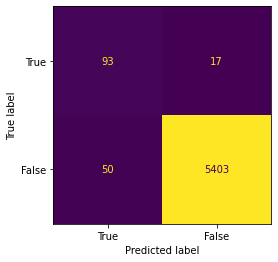

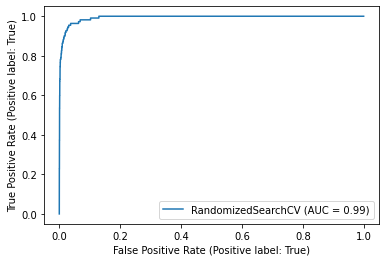

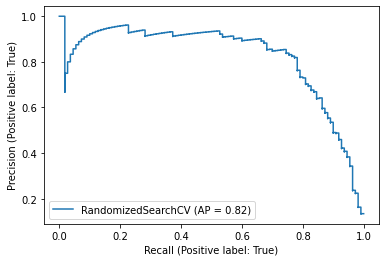

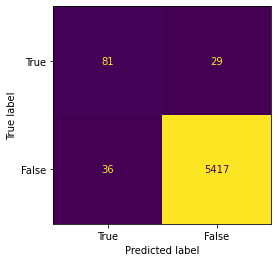

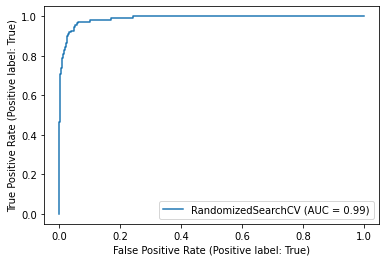

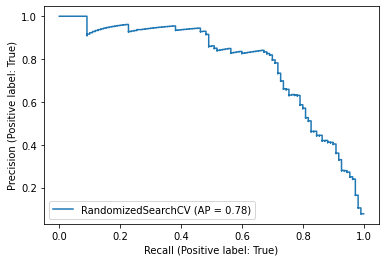

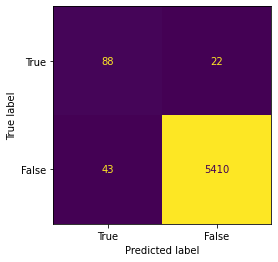

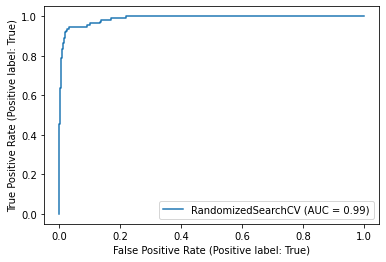

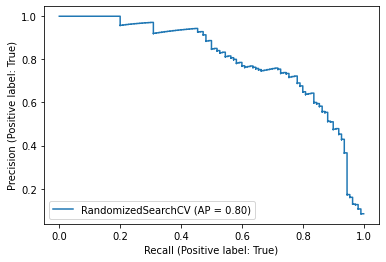

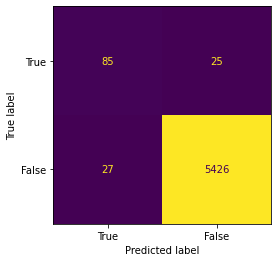

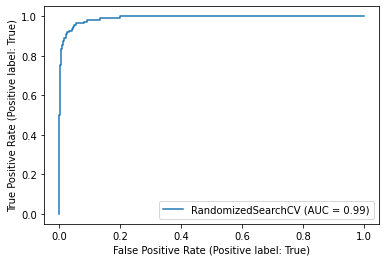

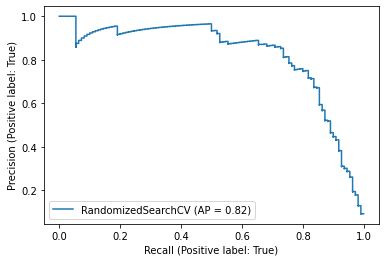

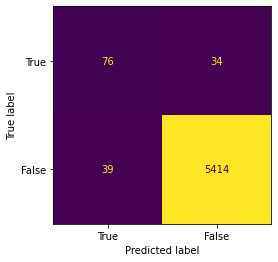

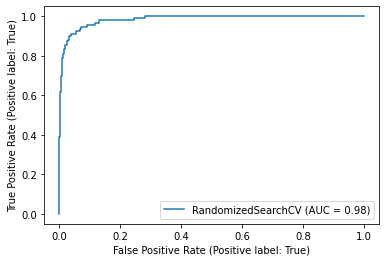

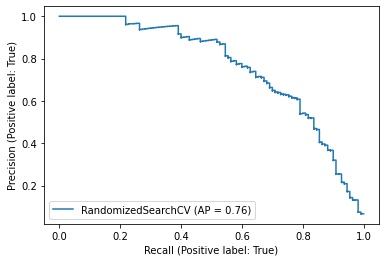

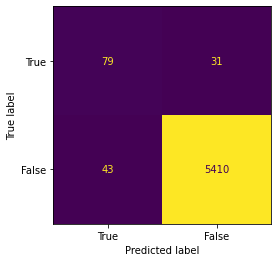

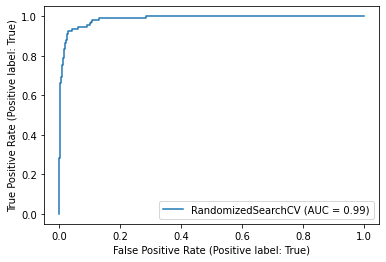

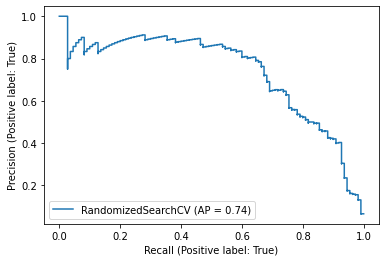

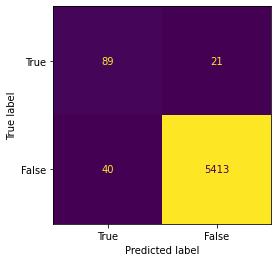

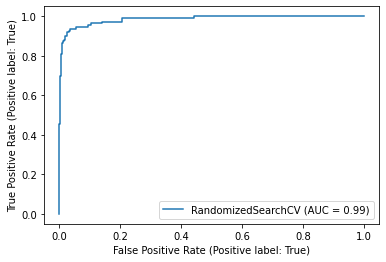

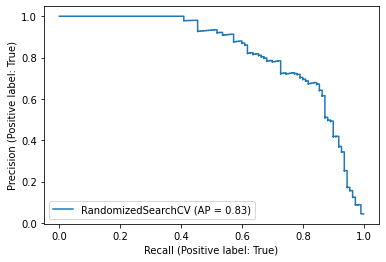

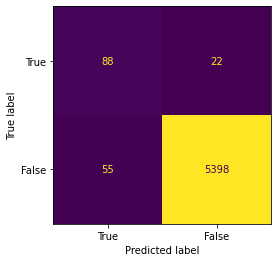

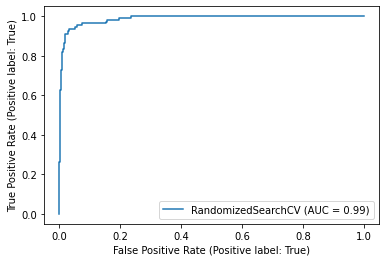

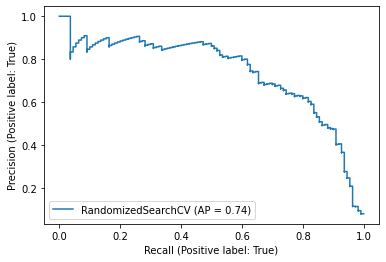

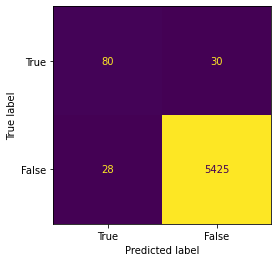

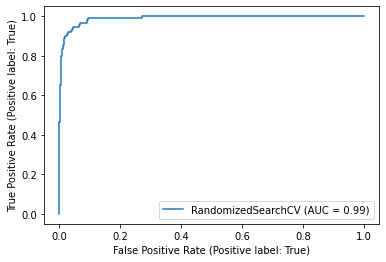

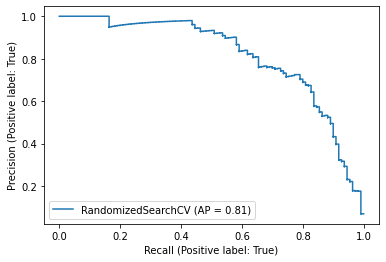

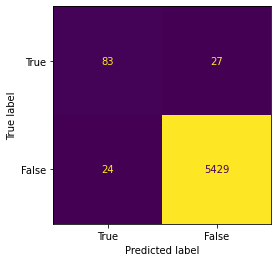

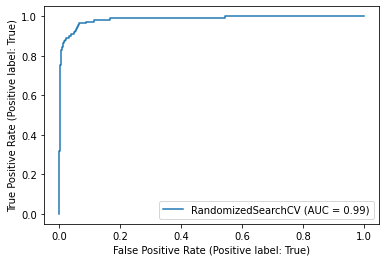

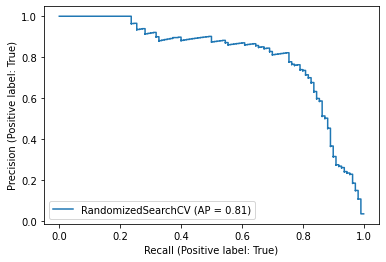

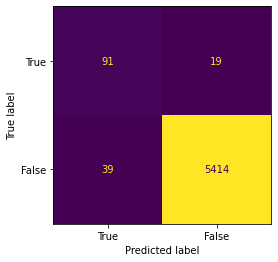

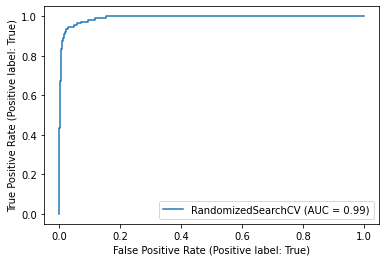

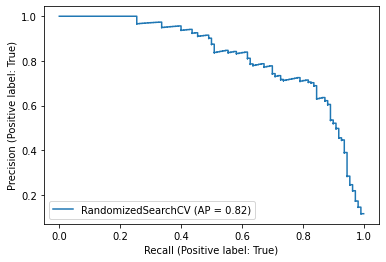

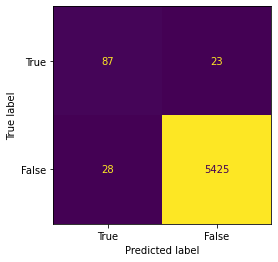

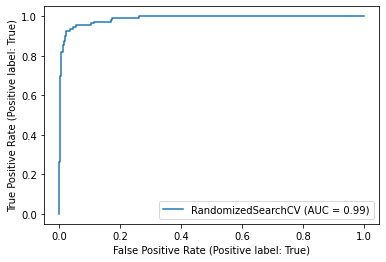

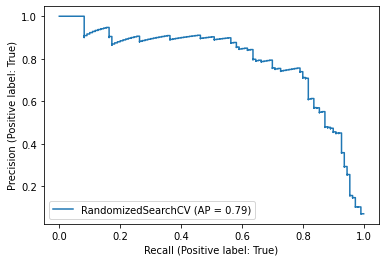

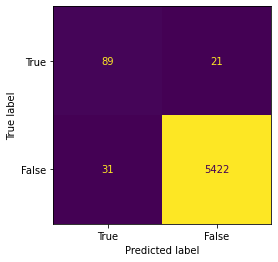

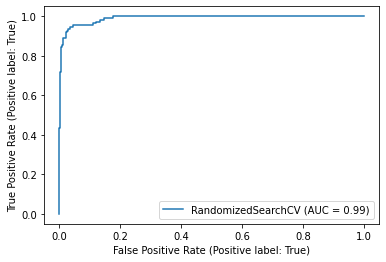

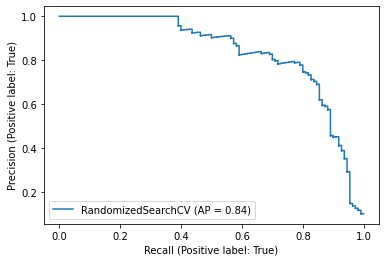

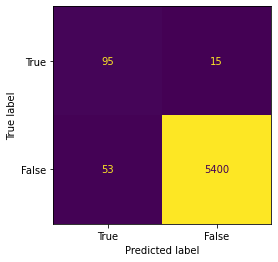

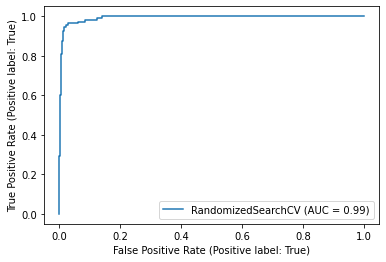

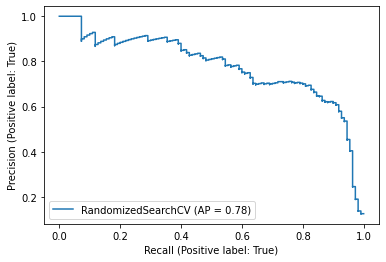

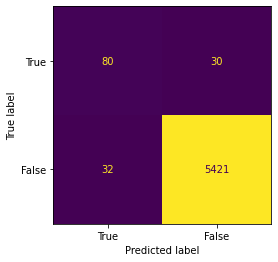

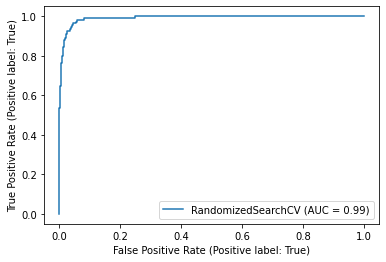

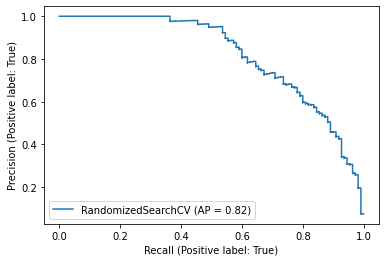

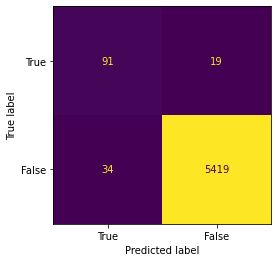

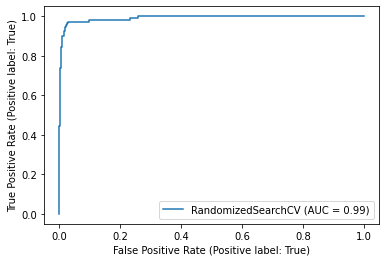

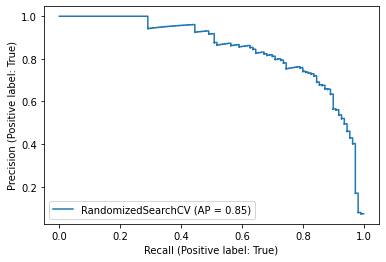

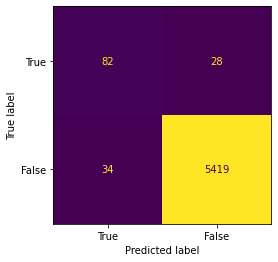

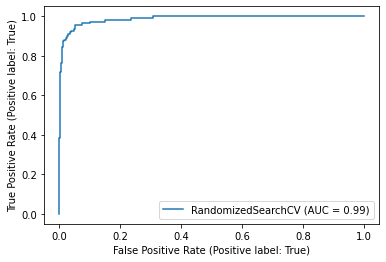

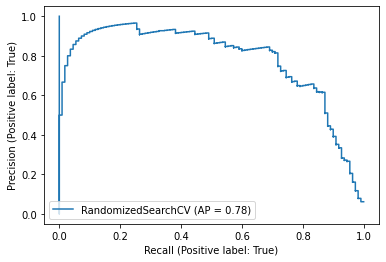

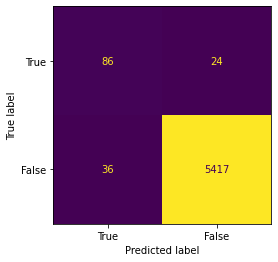

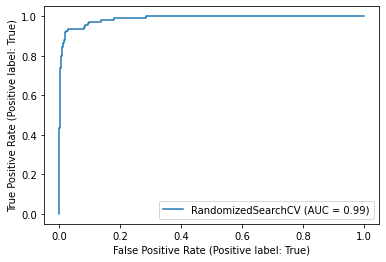

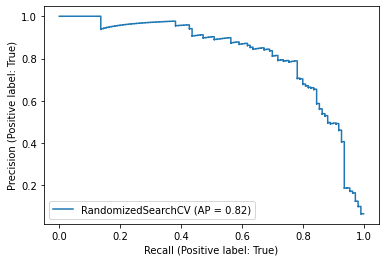

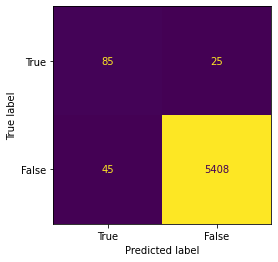

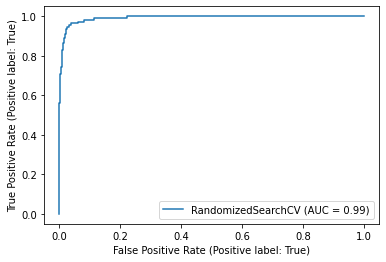

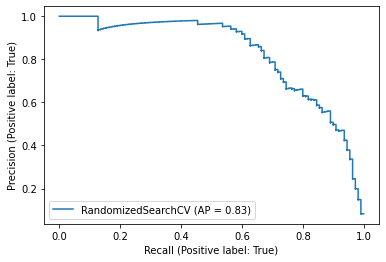

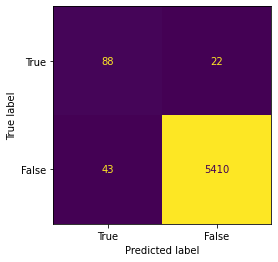

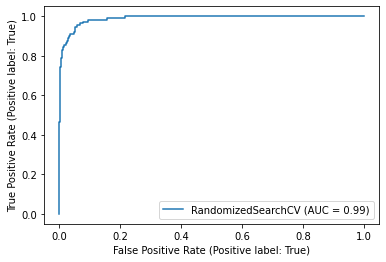

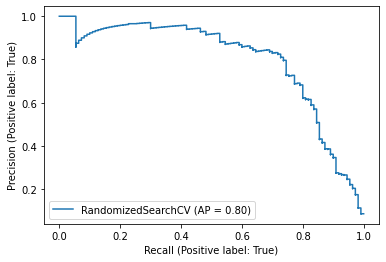

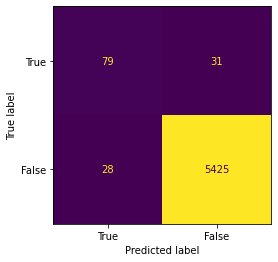

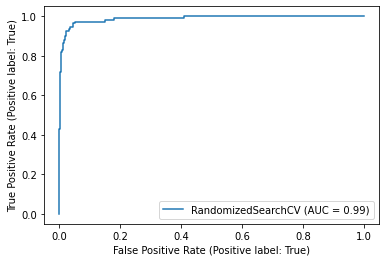

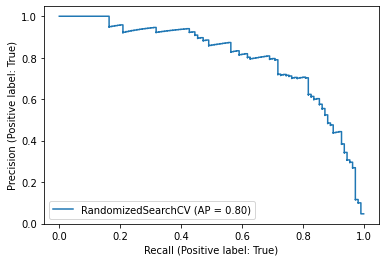

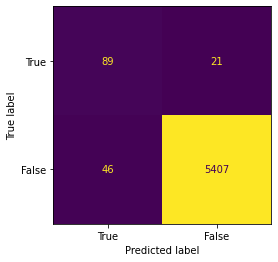

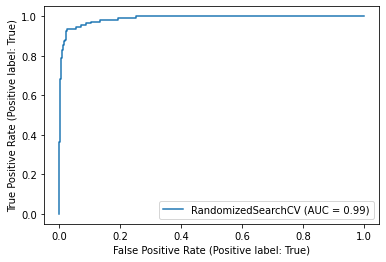

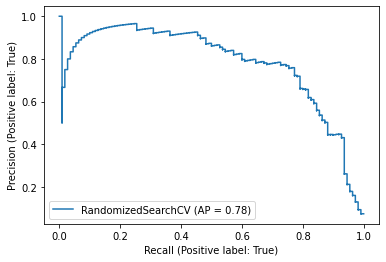

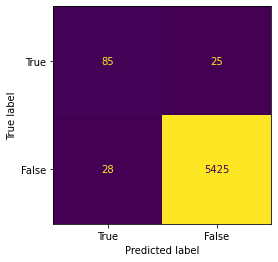

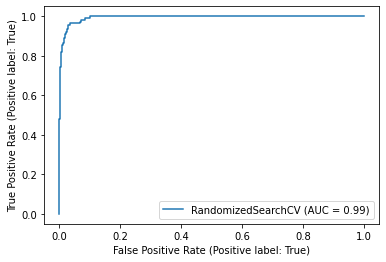

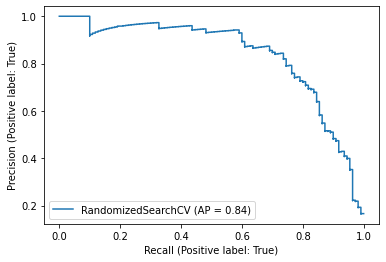

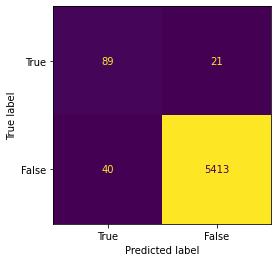

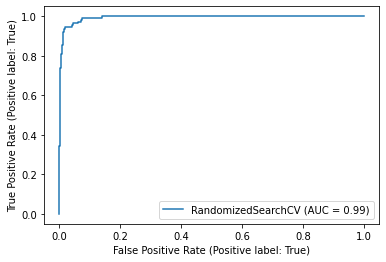

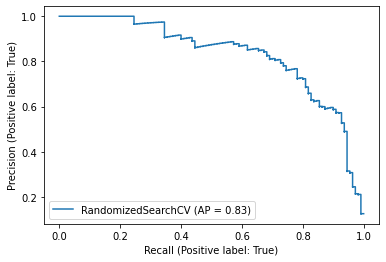

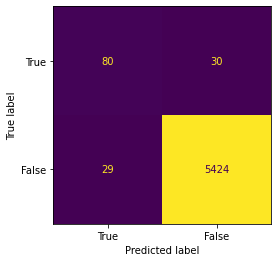

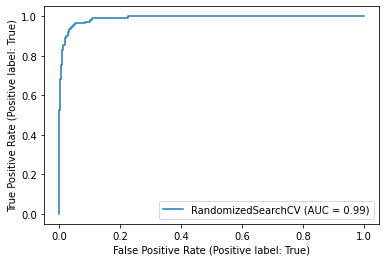

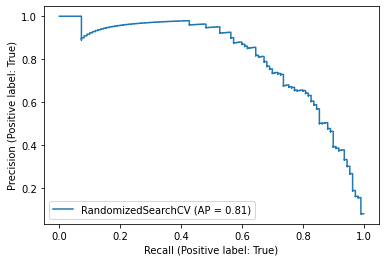

In [13]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

for i in range(25):

    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.5, n_jobs=-1)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]
    spaceEmpty = dict()

    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)